# Benchmarking

In this notebook we will benchmark our method for identifying circular structures against the synthetic dataset of Lederer at al. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy.stats as ss

from pathlib import Path
from ripser import ripser
from scipy.spatial import distance
from tqdm import tqdm
import torch

RANDOM_STATE = 240209

In [3]:
import velocycle as vc
from velocycle import *

from lederer_utils import simulate_data
from lederer_utils import circular_corrcoef

import pyro

# importing chunter in the velocycle environment -- a little complicated!

In [4]:
import os
import sys

# Use os.getcwd() to get the current working directory
current_dir = os.getcwd()

# Adjust the path accordingly. Here, we assume the project root is one directory up.
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)

# Now import your module
import src.chunter.chunter as chnt


# delineating spliced and unspliced

In [5]:
import anndata as ad

adata = simulate_data(Nc=100, Ng=300)

import anndata as ad

def create_spliced_unspliced_adata(adata):
    """
    Creates a new AnnData object with spliced and unspliced copies of each gene variable,
    along with concatenated spliced and unspliced layers as the count matrix.

    Parameters:
    adata (AnnData): Input AnnData object with 'spliced' and 'unspliced' layers.

    Returns:
    AnnData: New AnnData object with concatenated spliced and unspliced count matrix
             and duplicated metadata in var for each spliced and unspliced version.
    """
    # Ensure that spliced and unspliced layers are dense arrays (if they are sparse matrices)
    X_spliced = adata.layers["spliced"].toarray() if hasattr(adata.layers["spliced"], "toarray") else adata.layers["spliced"]
    X_unspliced = adata.layers["unspliced"].toarray() if hasattr(adata.layers["unspliced"], "toarray") else adata.layers["unspliced"]

    # Concatenate the spliced and unspliced matrices along the gene axis
    X_new = np.concatenate([X_spliced, X_unspliced], axis=1)

    # Duplicate `adata.var` metadata for spliced and unspliced versions of each gene
    var_spliced = adata.var.copy()
    var_spliced.index = var_spliced.index + "_spliced"

    var_unspliced = adata.var.copy()
    var_unspliced.index = var_unspliced.index + "_unspliced"

    # Combine the duplicated metadata
    var_new = pd.concat([var_spliced, var_unspliced])

    # Create the new AnnData object
    adata_new = ad.AnnData(X=X_new, obs=adata.obs.copy(), var=var_new)

    # Copy over uns metadata
    adata_new.uns = adata.uns.copy()

    return adata_new

/Users/kelly/Documents/code/chunter2/Synthetic/lederer_utils.py:523: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  simulated_ζ = torch.stack([torch_basis(simulated_phis[i], der=0, kind="fourier", **dict(num_harmonics=1)).T for i in range(Nc)])


Simulating 0.4


# Multiprocess simulations

In [6]:
import anndata

In [36]:
# parameters
n_cells = 1200
n_genes1 = 300
n_genes2 = 300
# process 1 -- a circular process
process1 = simulate_data(Nc=n_cells, Ng=n_genes1)

# process 2 -- the first half of a circular process
process2 = simulate_data(Nc=2*n_cells, Ng=n_genes2)

Simulating 0.4
Simulating 0.4


In [37]:
def create_multiprocess_adata(n_cells=1200, n_genes1=250, n_genes2=300):
    """
    Simulate and combine two processes into a multiprocess AnnData object.
    
    Process 1 is simulated as a circular process and Process 2 is simulated as the first half
    of a circular process. The function modifies gene names to distinguish the datasets,
    orders the cells in Process 2 by their simulated phase, and concatenates both datasets.
    Finally, it creates spliced and unspliced layers in the multiprocess AnnData object.

    Parameters:
    -----------
    n_cells : int, optional
        Number of cells for process1 and used for half of process2 (default is 1200).
    n_genes1 : int, optional
        Number of genes to simulate for process1 (default is 250).
    n_genes2 : int, optional
        Number of genes to simulate for process2 (default is 300).

    Returns:
    --------
    multiprocess : AnnData
        The multiprocess AnnData object after spliced and unspliced layers are created.
    multiprocess_raw : AnnData
        A raw copy of the multiprocess AnnData object before spliced/unspliced transformation.

    Notes:
    ------
    This function assumes that the following functions and modules have been imported:
      - simulate_data (for simulating the datasets)
      - anndata.concat (for concatenating the AnnData objects)
      - create_spliced_unspliced_adata (for adding spliced/unspliced layers)
    """
    # Process 1: Circular process
    process1 = simulate_data(Nc=n_cells, Ng=n_genes1)
    # Change var_names: Replace the first letter with "C"
    process1.var_names = ['C' + name[1:] for name in process1.var_names]

    # Process 2: First half of a circular process
    process2 = simulate_data(Nc=2 * n_cells, Ng=n_genes2)
    # Change var_names: Replace the first letter with "L"
    process2.var_names = ['L' + name[1:] for name in process2.var_names]

    # Order process2's cells by their simulated_phis values
    process2 = process2[process2.obs['simulated_phis'].sort_values().index, :]
    # Take only the first n_cells (representing the first half of the process)
    process2 = process2[:n_cells, :]
    # Resort process2 by simulated_phis
    process2 = process2[process2.obs['simulated_phis'].sort_values().index, :]

    # Retrieve the simulated phis for each process
    phis1 = process1.obs['simulated_phis'].values
    phis2 = process2.obs['simulated_phis'].values

    # Ensure process2 has the same cell names as process1 for concatenation
    process2.obs_names = process1.obs_names

    # Concatenate the two datasets along variables (i.e., axis=1)
    multiprocess = anndata.concat([process1, process2], axis=1)
    print(multiprocess)

    # Store the simulated phis in the multiprocess AnnData object
    multiprocess.obs['simulated_phis1'] = phis1
    multiprocess.obs['simulated_phis2'] = phis2 / phis2.max()

    # Make a raw copy of the multiprocess AnnData object
    multiprocess_raw = multiprocess.copy()

    # Create spliced and unspliced layers using a custom function
    multiprocess = create_spliced_unspliced_adata(multiprocess)

    multiprocess_raw.obs['batch'] = process1.obs['batch']

    return multiprocess, multiprocess_raw


In [38]:
# parameters
n_cells = 1200
n_genes1 = 250
n_genes2 = 300

# generate the data
multiprocess, multiprocess_raw = create_multiprocess_adata(n_cells=n_cells, n_genes1=n_genes1, n_genes2=n_genes2)

Simulating 0.4
Simulating 0.4
AnnData object with n_obs × n_vars = 1200 × 550
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas'
    layers: 'spliced', 'unspliced', 'simulated_ElogU', 'simulated_ElogS'


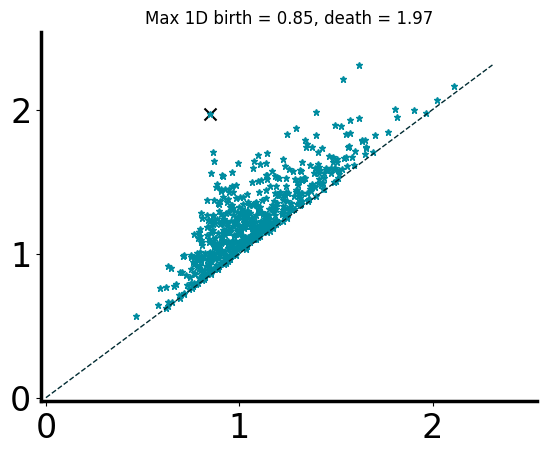

In [58]:
chnt.plot_diagram(multiprocess)

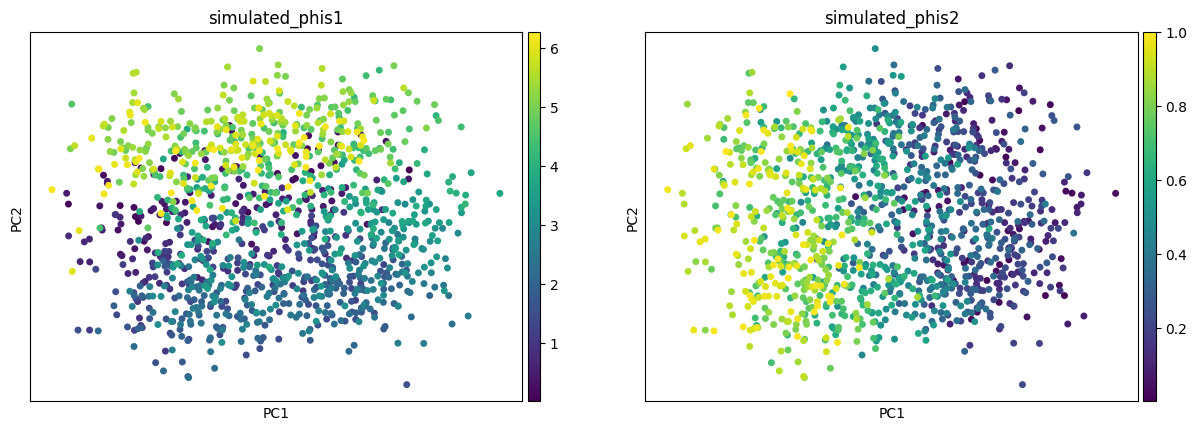

In [39]:
# Apply standard normalization
sc.pp.filter_genes(multiprocess, min_cells=3)
sc.pp.normalize_per_cell(multiprocess, counts_per_cell_after=1e4)
# Log transform the data and scale
sc.pp.log1p(multiprocess)


# pca on both
sc.tl.pca(multiprocess, n_comps=5)
sc.pl.pca(multiprocess, color = ['simulated_phis1', 'simulated_phis2'], use_raw=False)

# 3d scatter plot
chnt.scatter3D(multiprocess, color = 'simulated_phis1', title='3D Scatter Plot of Multiprocess Data: Circular Process', color_continuous_scale='hsv')
chnt.scatter3D(multiprocess, color = 'simulated_phis2', title='3D Scatter Plot of Multiprocess Data: Linear Process')

# Velocycle Multi-process

In [40]:
multiprocess_raw.obs['batch'] = process1.obs['batch']

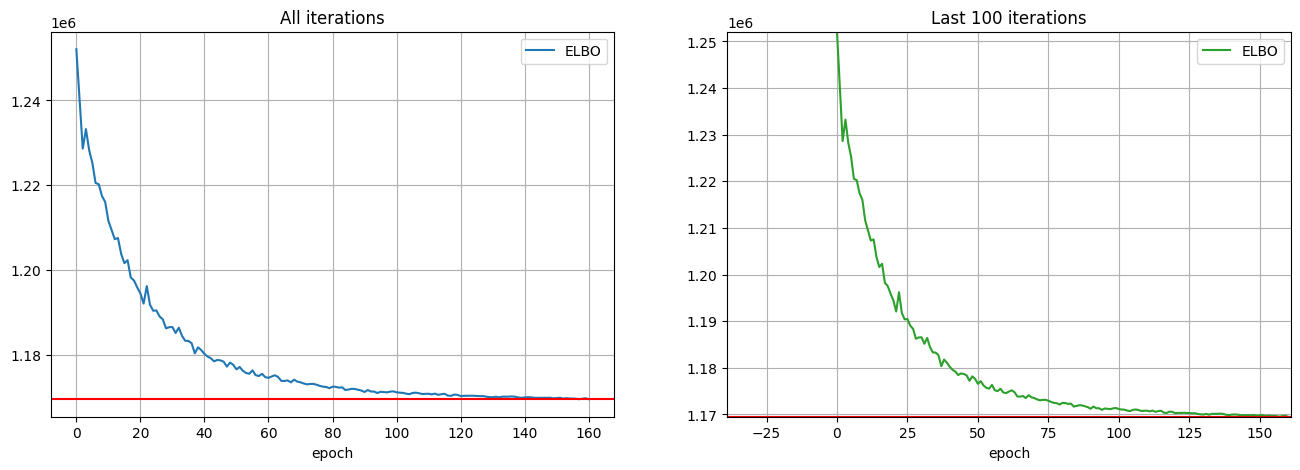

AnnData object with n_obs × n_vars = 1200 × 550
    obs: 'simulated_phis1', 'simulated_phis2', 'batch', 'n_scounts', 'n_ucounts', 'coords'
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas'
    layers: 'spliced', 'unspliced', 'simulated_ElogU', 'simulated_ElogS', 'S_sz', 'U_sz'

In [41]:
def velocycle_estimation(adata):

    adata = adata.copy()

    # VeloCycle operates on the raw counts and has a built-in count factor term
    preprocessing.normalize_total(adata)

    cycle_prior = cycle.Cycle.trivial_prior(gene_names=adata.var_names, harmonics=1)
    # Keep only genes from biologically-relevant gene set that are present in the current dataset
    cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, adata, filter_type="intersection")
    # Update the priors for gene harmonics
    # to gene-specific means and stds
    S = data_to_fit.layers['spliced'].toarray()
    S_means = S.mean(axis=0) #sum over cells
    nu0 = np.log(S_means)

    # Mean prior
    S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
    cycle_prior.set_means(S_frac_means)

    # Standard deviation prior
    nu0std = np.std(np.log(S+1), axis=0)/2
    S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
    cycle_prior.set_stds(S_frac_stds)
    # Obtain a PCA prior for individual cell phases
    # The prior for cell cycle coordinates are taken from the first two components of the PCA
    # This is the only step of the model that relies on log transformed counts - but still no smoothing is performed
    data_to_fit.layers["S_sz_log"] = np.log(data_to_fit.layers["S_sz"]+1)
    phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                                genes_to_use=adata.var_names, 
                                                layer='S_sz_log',
                                                concentration=5.0, plot=True, small_count=1)
    USE_GPU = True
    if USE_GPU and torch.cuda.is_available():
        print("Will use GPU")
        device = torch.device("cuda:0")
    else:
        print("Will use CPU")
        device = torch.device("cpu")

        # Create design matrix for dataset with a single sample/batch
    batch_design_matrix = preprocessing.make_design_matrix(adata, ids="batch")
    pyro.clear_param_store()

    # Call a preprocessing function to metaparameters to provide to Pyro
    metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                            cycle_obj=cycle_prior, 
                                            phase_obj=phase_prior, 
                                            design_mtx=batch_design_matrix,
                                            n_harmonics=1,
                                            device = device,
                                            with_delta_nu=False)


    # Define a pyro object for phase inference
    phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar)


    # Perform training using a decaying learning rate
    num_steps = 200
    initial_lr = 0.03
    final_lr = 0.005
    gamma = final_lr / initial_lr
    lrd = gamma ** (1 / num_steps)
    adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

    phase_fit.fit(optimizer=adam, num_steps=num_steps)

    adata.obs['coords'] = (np.array(phase_fit.phase_pyro.phis) + np.pi)/(2*np.pi)

    return adata.copy()


adata = multiprocess_raw.copy()

adata = velocycle_estimation(adata)

adata

In [42]:
multiprocess.obs['velocycle_coords'] = adata.obs['coords'].values

In [43]:
chnt.circular(multiprocess, comp = [0,1,2])

0.21001248359680177


AnnData object with n_obs × n_vars = 1200 × 1098
    obs: 'simulated_phis1', 'simulated_phis2', 'n_counts', 'velocycle_coords', 'coords', 'log_counts'
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas', 'n_cells'
    uns: 'log1p', 'pca', 'circular'
    obsm: 'X_pca'
    varm: 'PCs'

In [57]:
chnt.scatter3D(multiprocess, color = 'coords', title='3D Scatter Plot of Multiprocess Data: Chunter Predictions', color_continuous_scale='hsv')

In [56]:
chnt.scatter3D(multiprocess, color = 'velocycle_coords', title='3D Scatter Plot of Multiprocess Data: Velocycle Predictions', color_continuous_scale='hsv')

In [54]:
#chnt.reverse(multiprocess)
chnt.reparametrize(multiprocess,0.1)

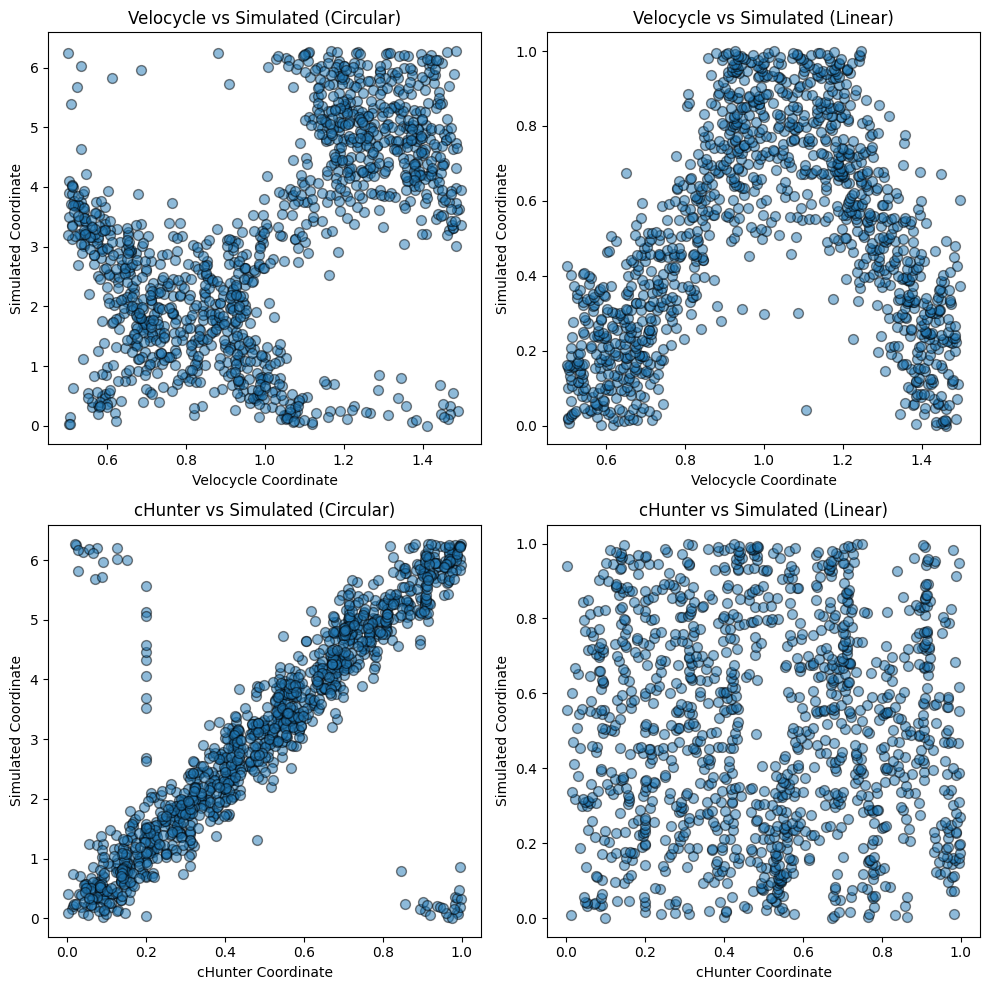

In [55]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Panel 1: velocycle_coords vs simulated_phis1 (Circular Process)
axs[0, 0].scatter(multiprocess.obs['velocycle_coords'], multiprocess.obs['simulated_phis1'],
                  s=50, alpha=0.5, edgecolors='k', label='Circular Process Coordinate')
axs[0, 0].set_xlabel('Velocycle Coordinate')
axs[0, 0].set_ylabel('Simulated Coordinate')
axs[0, 0].set_title('Velocycle vs Simulated (Circular)')

# Panel 2: velocycle_coords vs simulated_phis2 (Linear Process)
axs[0, 1].scatter(multiprocess.obs['velocycle_coords'], multiprocess.obs['simulated_phis2'],
                  s=50, alpha=0.5, edgecolors='k', label='Linear Process Coordinate')
axs[0, 1].set_xlabel('Velocycle Coordinate')
axs[0, 1].set_ylabel('Simulated Coordinate')
axs[0, 1].set_title('Velocycle vs Simulated (Linear)')


# Panel 3: coords vs simulated_phis1 (Circular Process)
axs[1, 0].scatter(multiprocess.obs['coords'], multiprocess.obs['simulated_phis1'],
                  s=50, alpha=0.5, edgecolors='k', label='Circular Process Coordinate')
axs[1, 0].set_xlabel('cHunter Coordinate')
axs[1, 0].set_ylabel('Simulated Coordinate')
axs[1, 0].set_title('cHunter vs Simulated (Circular)')

# Panel 4: coords vs simulated_phis2 (Linear Process)
axs[1, 1].scatter(multiprocess.obs['coords'], multiprocess.obs['simulated_phis2'],
                  s=50, alpha=0.5, edgecolors='k', label='Linear Process Coordinate')
axs[1, 1].set_xlabel('cHunter Coordinate')
axs[1, 1].set_ylabel('Simulated Coordinate')
axs[1, 1].set_title('cHunter vs Simulated (Linear)')


plt.tight_layout()
plt.show()


# Multi-process Benchmarking

We need a function to align the estimated phase with the ground truth phase.

In [121]:
import numpy as np
import matplotlib.pyplot as plt

def compute_final_circular_corrcoef_with_plotting(adata, plotting=True):
    """
    Recenters the data by the coordinate value of the cells with the lowest 2% simulated phi values,
    reverses the coordinates if the initial circular correlation coefficient is less than 0.35, 
    and returns the final circular correlation coefficient. Optionally plots the original, 
    reparametrized, and reversed data.

    Parameters:
    -----------
    adata : AnnData object
        The annotated data matrix containing the obs and var data.
    plotting : bool, optional
        If True, plots of the data states will be displayed (default is True).

    Returns:
    --------
    float
        The final circular correlation coefficient after alignment and possible reversal.
    """
    
    # Initial computations
    coords = 2 * np.pi * adata.obs['coords']
    simulated_phis = adata.obs['simulated_phis1']
    
    # Plot the original data if plotting is enabled
    if plotting:
        plt.figure(figsize=(12, 6))
        plt.scatter(adata.obs['coords'], simulated_phis, label='Original', alpha=0.6)
    
    # Find indexes of cells in the lowest 2% of simulated phi values
    threshold_phi = np.percentile(simulated_phis, 2)
    low_phi_indexes = adata.obs['simulated_phis1'] <= threshold_phi
    
    # Compute the prior circular correlation coefficient
    prior_corr = circular_corrcoef(2 * np.pi * adata.obs['coords'], simulated_phis)
    print("Prior circular correlation coefficient:", prior_corr)
    
    # Compute the average coordinate value of the low phi cells
    recenter_value = adata.obs['coords'][low_phi_indexes].mean()
    
    # Reparametrize by subtracting the recenter value and wrapping around using modulo
    adata.obs['coords'] -= recenter_value
    adata.obs['coords'] %= 1  # Ensure coords are still within [0, 1)
    
    # Recompute coordinates after reparametrization
    coords = 2 * np.pi * adata.obs['coords']
    
    # Plot the reparametrized data if plotting is enabled
    if plotting:
        plt.scatter(adata.obs['coords'], simulated_phis, label='Reparametrized', alpha=0.6)
    
    # Compute the initial circular correlation coefficient after reparametrization
    initial_corr = circular_corrcoef(2 * np.pi * adata.obs['coords'], simulated_phis)
    print(f'Initial circular correlation coefficient: {initial_corr}')
    
    # Reverse the coordinates if the initial correlation is lower than 0.35
    if initial_corr < 0.35:
        adata.obs['coords'] = 1 - adata.obs['coords']
        if plotting:
            plt.scatter(adata.obs['coords'], simulated_phis, label='Reversed', alpha=0.6)
    
    # Compute the final circular correlation coefficient
    circular_corr = circular_corrcoef(2 * np.pi * adata.obs['coords'], simulated_phis)
    max_corr = np.max([prior_corr, initial_corr, circular_corr])
    
    # Plot final settings if plotting is enabled
    if plotting:
        plt.xlabel('Coords')
        plt.ylabel('Simulated Phis')
        plt.legend()
        plt.title(f'Final Circular Correlation Coefficient: {max_corr:.4f}')
        plt.show()
    
    print(f'Final circular correlation coefficient: {max_corr}')
    
    return circular_corr


We run the method on the Lederer et al. synthetic dataset over the same parameter set of number of genes and cells. For each, we compute:
- The circular correlation between the gorund truth and the simulated phase.
- The ring score (both diameter and ratio) of the data transformed onto the first 3 principal components.

We recover a similar pattern to Lederer at. al, where the circular correlation increases with both number of genes and number of cells. We observe that the ring score follows the same patterns. We argue that this demonstrates the viability of using the ring score as preprocessing step for the existence of circular structure in data, prior to applying our method or any other that assumes circular structure.

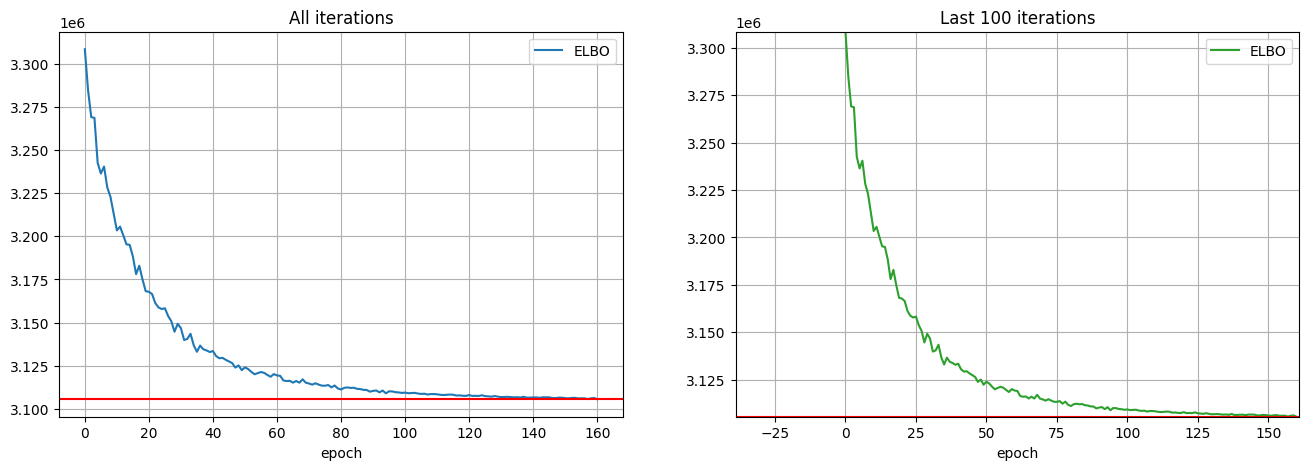

Prior circular correlation coefficient: 0.39682138264060773
Initial circular correlation coefficient: 0.3968213880180653
Final circular correlation coefficient: 0.3968213880180653
0.16245331764221194
Prior circular correlation coefficient: 0.002646837040447532
Initial circular correlation coefficient: 0.0026468370404475303
Final circular correlation coefficient: 0.9212555597619997


Processing Nc values: 100%|██████████| 1/1 [21:08<00:00, 1268.25s/it]

Prior circular correlation coefficient: 0.5266006250338587
Initial circular correlation coefficient: 0.5266005981568912
Final circular correlation coefficient: 0.5266006250338587


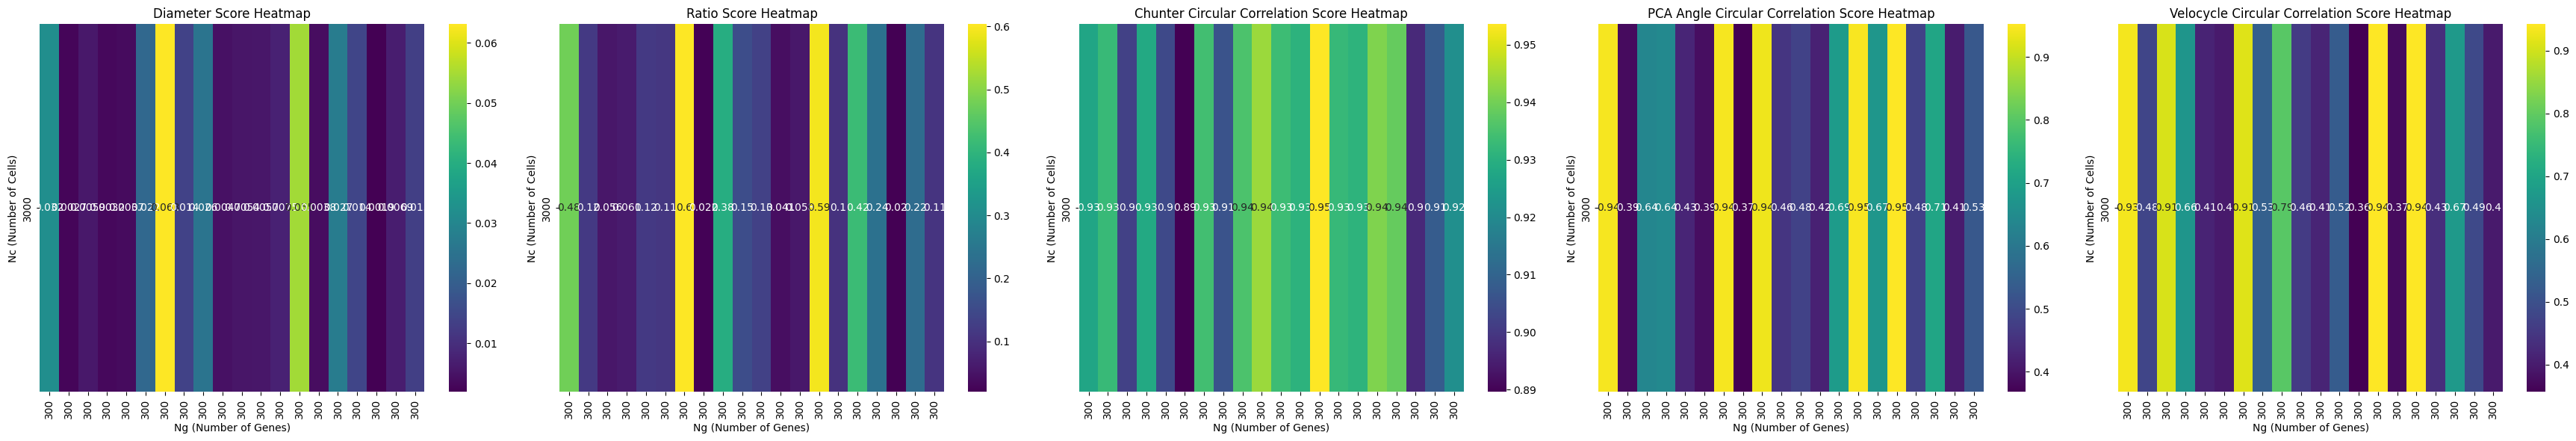

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bars

# Define the ranges for Nc and Ng
# Ng_values = [100, 200, 350, 500, 750, 1000]
# Nc_values = [100, 200, 500, 1000, 3000]

Ng_values = [300] * 20
Nc_values = [3000]

# Initialize arrays to hold the scores
diam_scores = np.zeros((len(Nc_values), len(Ng_values)))
ratio_scores = np.zeros((len(Nc_values), len(Ng_values)))
circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
pca_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
velocycle_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))

# Loop over the different values of Nc and Ng using tqdm progress bars
for i, Nc in enumerate(tqdm(Nc_values, desc="Processing Nc values")):
    for j, Ng in enumerate(tqdm(Ng_values, desc="Processing Ng values", leave=False)):
        print(f'Nc: {Nc}, Ng: {Ng}')
        
        # Simulate the data
        adata, adata_raw = create_multiprocess_adata(n_cells=Nc, n_genes1=Ng, n_genes2=Ng)
        
        velocycle_adata = velocycle_estimation(adata_raw)
        velocycle_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(velocycle_adata, plotting = False)
        
        # Apply standard normalization
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        
        # Log transform the data and scale
        sc.pp.log1p(adata)
        
        # PCA
        sc.pp.pca(adata, n_comps=3, use_highly_variable=False, random_state=RANDOM_STATE)
        
        # Calculate the diameter and ratio scores
        diam_score = chnt.ring_score(adata, score_type='diameter', exponent=2, comp=np.arange(2))
        ratio_score = chnt.ring_score(adata, score_type='ratio', exponent=2, comp=np.arange(2))
        
        # Store the results
        diam_scores[i, j] = diam_score
        ratio_scores[i, j] = ratio_score
        
        # Calculate the circular correlation using Chunter's method
        chnt.circular(adata, comp=[0, 1, 2])
        circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(adata, plotting=False)
        
        # Calculate the circular correlation for the PCA-derived angles
        angles = np.arctan2(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1])
        pca_adata = adata.copy()
        pca_adata.obs['coords'] = (angles + np.pi) / (2 * np.pi)
        pca_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(pca_adata, plotting=False)

# Plot the results as heatmaps
fig, axes = plt.subplots(1, 5, figsize=(35, 6))

sns.heatmap(diam_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[0], cmap='viridis', annot=True)
axes[0].set_title('Diameter Score Heatmap')
axes[0].set_xlabel('Ng (Number of Genes)')
axes[0].set_ylabel('Nc (Number of Cells)')

sns.heatmap(ratio_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[1], cmap='viridis', annot=True)
axes[1].set_title('Ratio Score Heatmap')
axes[1].set_xlabel('Ng (Number of Genes)')
axes[1].set_ylabel('Nc (Number of Cells)')

sns.heatmap(circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[2], cmap='viridis', annot=True)
axes[2].set_title('Chunter Circular Correlation Score Heatmap')
axes[2].set_xlabel('Ng (Number of Genes)')
axes[2].set_ylabel('Nc (Number of Cells)')

sns.heatmap(pca_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[3], cmap='viridis', annot=True)
axes[3].set_title('PCA Angle Circular Correlation Score Heatmap')
axes[3].set_xlabel('Ng (Number of Genes)')
axes[3].set_ylabel('Nc (Number of Cells)')

sns.heatmap(velocycle_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[4], cmap='viridis', annot=True)
axes[4].set_title('Velocycle Circular Correlation Score Heatmap')
axes[4].set_xlabel('Ng (Number of Genes)')
axes[4].set_ylabel('Nc (Number of Cells)')

plt.tight_layout()
plt.show()

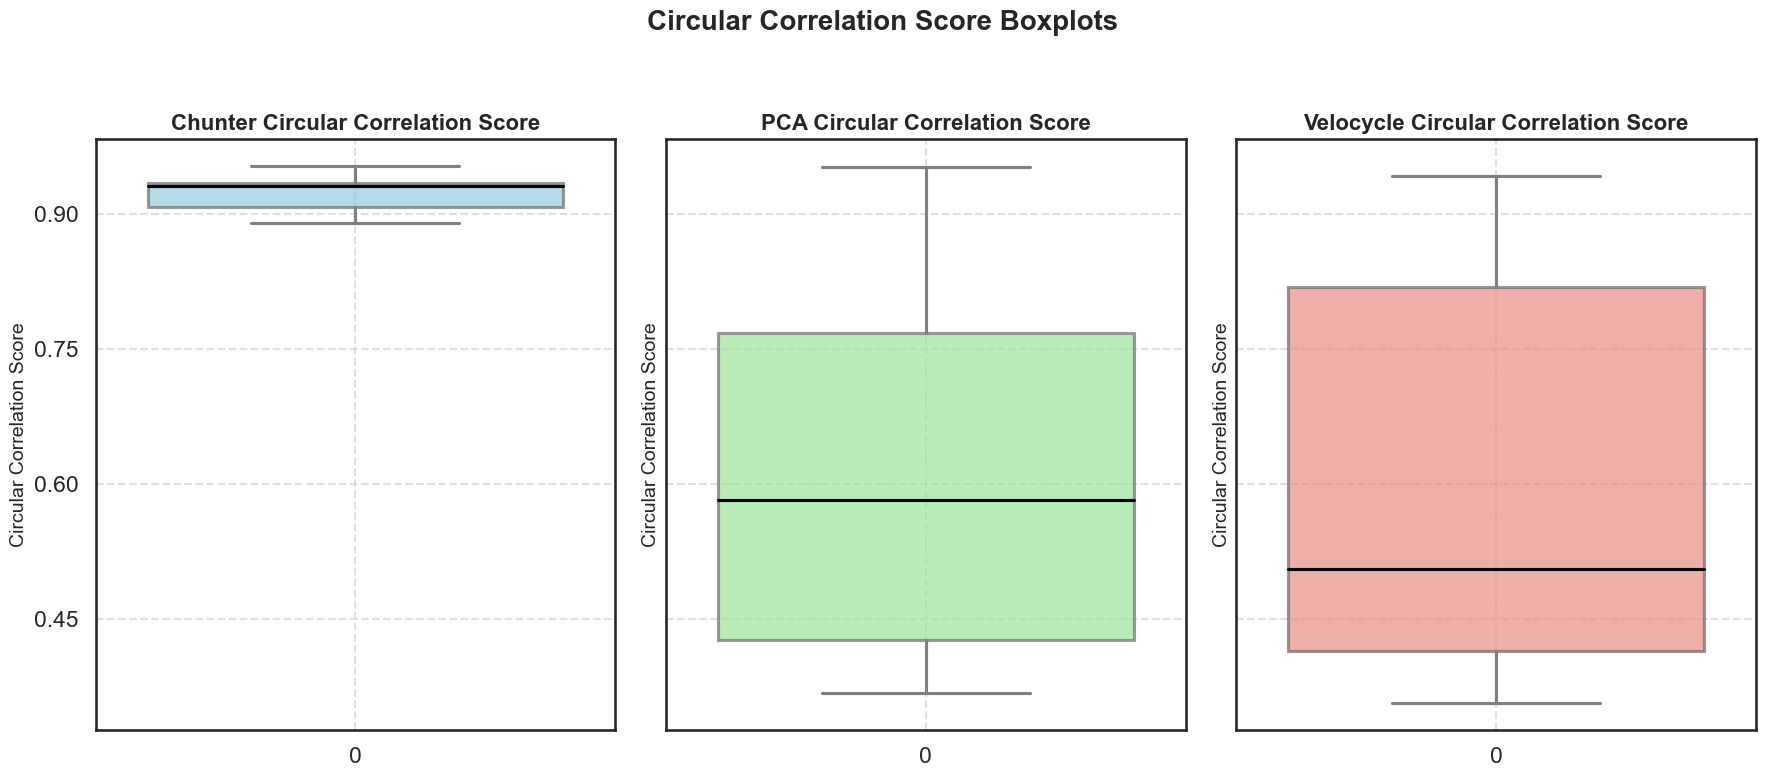

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Set a nice style with Seaborn
sns.set(style="white", context="talk")

# Create the box plots of the circular correlation scores
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Combine all data arrays to compute global y-limits
all_data = np.concatenate([
    circ_correlation.ravel(), 
    pca_circ_correlation.ravel(), 
    velocycle_circ_correlation.ravel()
])
ymin, ymax = all_data.min(), all_data.max()
margin = 0.05 * (ymax - ymin)
ymin -= margin
ymax += margin

# Titles and custom colors for each boxplot
titles = [
    'Chunter Circular Correlation Score',
    'PCA Circular Correlation Score',
    'Velocycle Circular Correlation Score'
]
# These colors are chosen for visual distinction
colors = ['skyblue', 'lightgreen', 'salmon']

datasets = [circ_correlation, pca_circ_correlation, velocycle_circ_correlation]

# Loop over the datasets and corresponding axes to plot the boxplots
for ax, data, title, color in zip(axes, datasets, titles, colors):
    # Plot the boxplot with custom properties
    sns.boxplot(
        data=data, orient='v', ax=ax, color=color,
        boxprops={'alpha': 0.7},            # semi-transparent boxes
        medianprops={'color': 'black'},     # black median lines
        whiskerprops={'color': 'grey'},
        capprops={'color': 'grey'}
    )
    
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_ylabel('Circular Correlation Score', fontsize=14)
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Automatically choose ~6 ticks
    # Add a dashed grid for better visual reference
    ax.grid(True, linestyle='--', alpha=0.6)

# Add an overall title and adjust the layout to prevent overlap
plt.suptitle("Circular Correlation Score Boxplots", fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Variable gene and cell counts

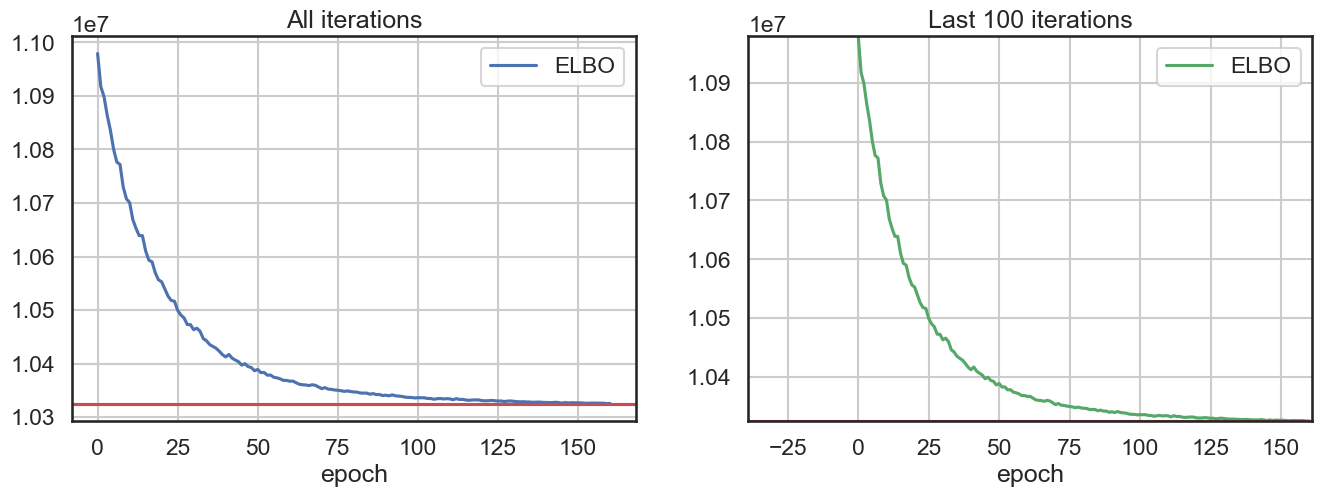

Prior circular correlation coefficient: 0.9798812518824926
Initial circular correlation coefficient: 0.9798812552654966
Final circular correlation coefficient: 0.9798812552654966
0.3947640657424927
Prior circular correlation coefficient: 0.9874004968577483
Initial circular correlation coefficient: 0.9874004968577483
Final circular correlation coefficient: 0.9874004968577483


Processing Nc values: 100%|██████████| 5/5 [15:20<00:00, 184.19s/it]

Prior circular correlation coefficient: 0.14488570533953443
Initial circular correlation coefficient: 0.1448857224635748
Final circular correlation coefficient: 0.894270684198109


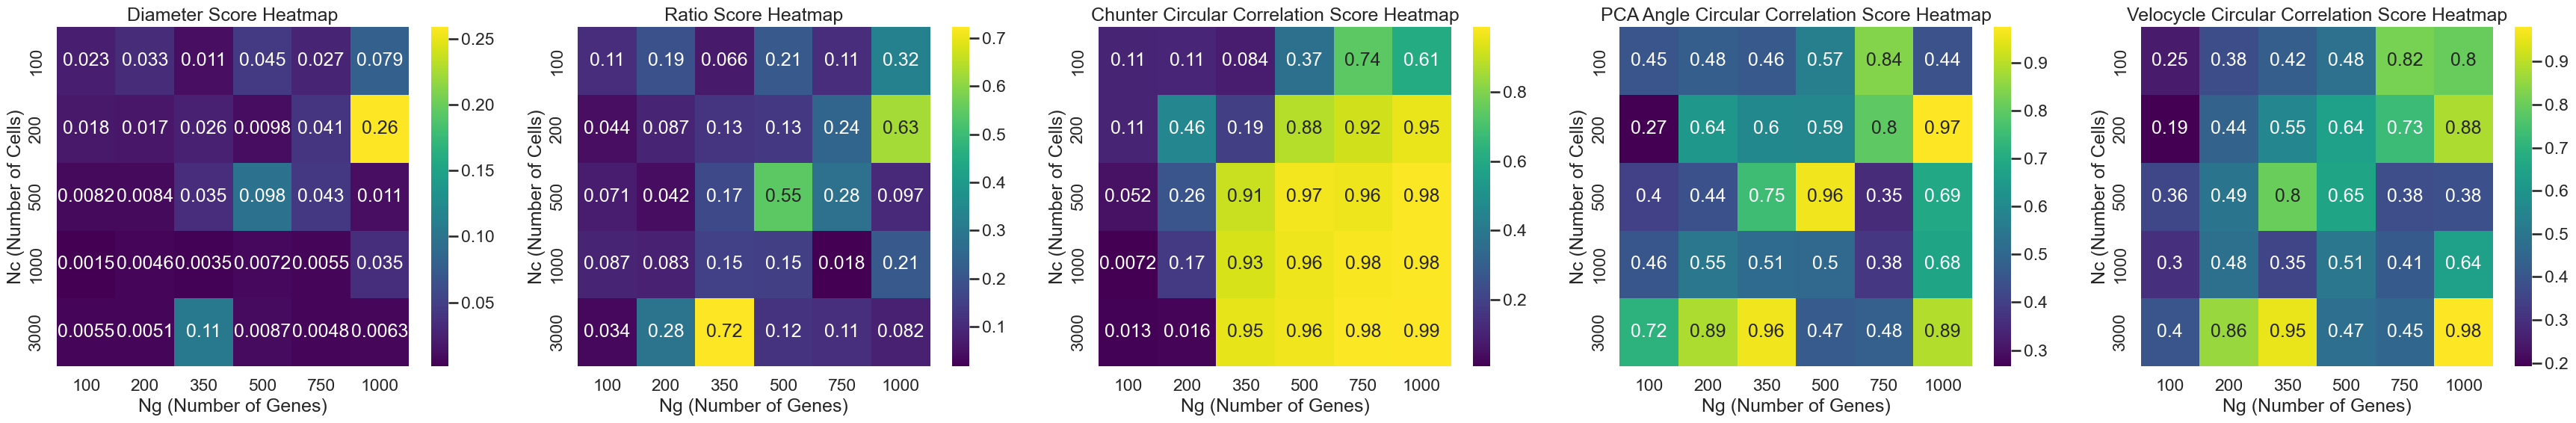

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bars

# Define the ranges for Nc and Ng
Ng_values = [100, 200, 350, 500, 750, 1000]
Nc_values = [100, 200, 500, 1000, 3000]

# Ng_values = [300] * 20
# Nc_values = [3000]

# Initialize arrays to hold the scores
diam_scores = np.zeros((len(Nc_values), len(Ng_values)))
ratio_scores = np.zeros((len(Nc_values), len(Ng_values)))
circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
pca_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
velocycle_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))

# Loop over the different values of Nc and Ng using tqdm progress bars
for i, Nc in enumerate(tqdm(Nc_values, desc="Processing Nc values")):
    for j, Ng in enumerate(tqdm(Ng_values, desc="Processing Ng values", leave=False)):
        print(f'Nc: {Nc}, Ng: {Ng}')
        
        # Simulate the data
        adata, adata_raw = create_multiprocess_adata(n_cells=Nc, n_genes1=Ng, n_genes2=Ng)
        
        velocycle_adata = velocycle_estimation(adata_raw)
        velocycle_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(velocycle_adata, plotting = False)
        
        # Apply standard normalization
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        
        # Log transform the data and scale
        sc.pp.log1p(adata)
        
        # PCA
        sc.pp.pca(adata, n_comps=3, use_highly_variable=False, random_state=RANDOM_STATE)

        # Calculate the circular correlation for the PCA-derived angles
        angles = np.arctan2(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1])
        pca_adata = adata.copy()
        pca_adata.obs['coords'] = (angles + np.pi) / (2 * np.pi)
        pca_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(pca_adata, plotting=False)
        
        # Calculate the diameter and ratio scores
        diam_score = chnt.ring_score(adata, score_type='diameter', exponent=2, comp=np.arange(2))
        ratio_score = chnt.ring_score(adata, score_type='ratio', exponent=2, comp=np.arange(2))
        
        # Store the results
        diam_scores[i, j] = diam_score
        ratio_scores[i, j] = ratio_score

        # filter by density
        adata = chnt.filter_cells_by_density(adata, lower_percentile=5, upper_percentile=100)
        

        # Calculate the circular correlation using Chunter's method
        chnt.circular(adata, comp=[0, 1, 2])
        circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(adata, plotting=False)
        
        
# Plot the results as heatmaps
fig, axes = plt.subplots(1, 5, figsize=(35, 6))

sns.heatmap(diam_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[0], cmap='viridis', annot=True)
axes[0].set_title('Diameter Score Heatmap')
axes[0].set_xlabel('Ng (Number of Genes)')
axes[0].set_ylabel('Nc (Number of Cells)')

sns.heatmap(ratio_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[1], cmap='viridis', annot=True)
axes[1].set_title('Ratio Score Heatmap')
axes[1].set_xlabel('Ng (Number of Genes)')
axes[1].set_ylabel('Nc (Number of Cells)')

sns.heatmap(circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[2], cmap='viridis', annot=True)
axes[2].set_title('Chunter Circular Correlation Score Heatmap')
axes[2].set_xlabel('Ng (Number of Genes)')
axes[2].set_ylabel('Nc (Number of Cells)')

sns.heatmap(pca_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[3], cmap='viridis', annot=True)
axes[3].set_title('PCA Angle Circular Correlation Score Heatmap')
axes[3].set_xlabel('Ng (Number of Genes)')
axes[3].set_ylabel('Nc (Number of Cells)')

sns.heatmap(velocycle_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[4], cmap='viridis', annot=True)
axes[4].set_title('Velocycle Circular Correlation Score Heatmap')
axes[4].set_xlabel('Ng (Number of Genes)')
axes[4].set_ylabel('Nc (Number of Cells)')

plt.tight_layout()
plt.show()

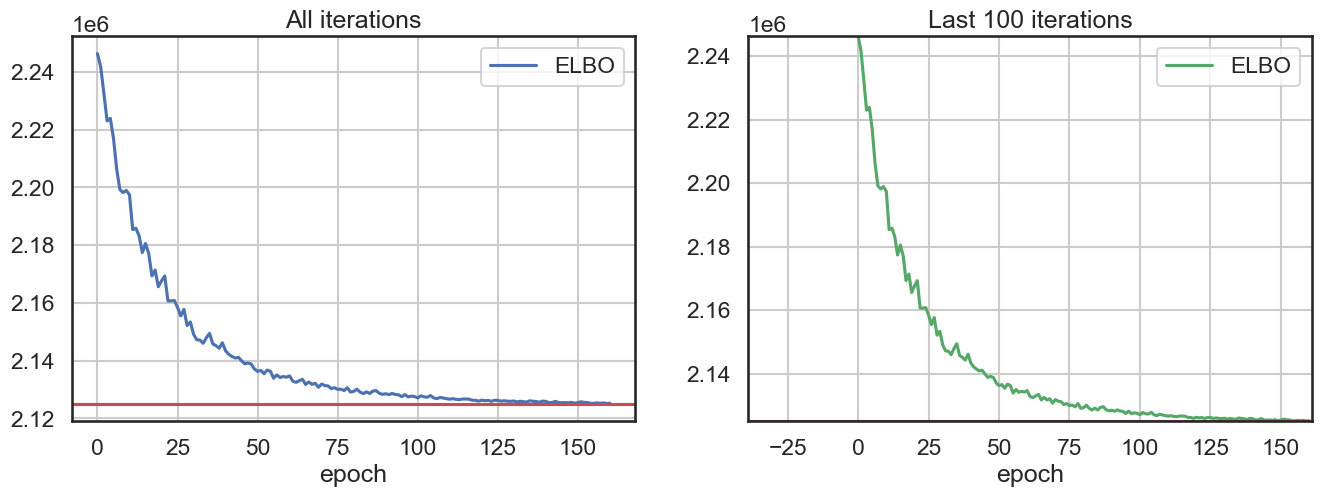

Prior circular correlation coefficient: 0.3962379556984328
Initial circular correlation coefficient: 0.39623790207789966
Final circular correlation coefficient: 0.3962379556984328
Prior circular correlation coefficient: 0.5224432947484384
Initial circular correlation coefficient: 0.5224433358345516
Final circular correlation coefficient: 0.5224433358345516
0.00023875450270068196


Processing Nc values: 100%|██████████| 3/3 [02:13<00:00, 44.63s/it]

Prior circular correlation coefficient: 0.01981720446680758
Initial circular correlation coefficient: 0.019817204466807584
Final circular correlation coefficient: 0.02692204392715336


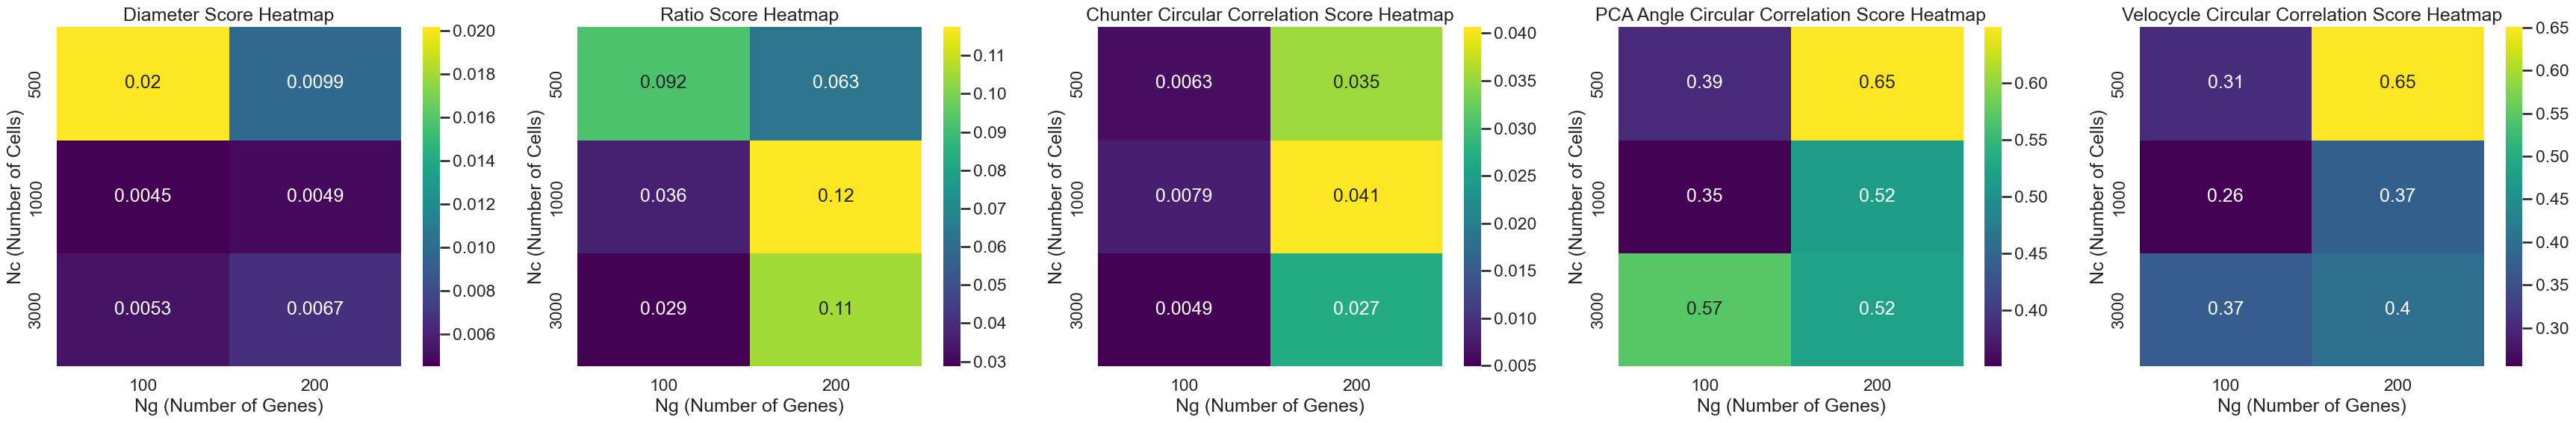

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bars

# Define the ranges for Nc and Ng
Ng_values = [100, 200]
Nc_values = [500, 1000, 3000]

# Ng_values = [300] * 20
# Nc_values = [3000]

# Initialize arrays to hold the scores
diam_scores = np.zeros((len(Nc_values), len(Ng_values)))
ratio_scores = np.zeros((len(Nc_values), len(Ng_values)))
circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
pca_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
velocycle_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))

# Loop over the different values of Nc and Ng using tqdm progress bars
for i, Nc in enumerate(tqdm(Nc_values, desc="Processing Nc values")):
    for j, Ng in enumerate(tqdm(Ng_values, desc="Processing Ng values", leave=False)):
        print(f'Nc: {Nc}, Ng: {Ng}')
        
        # Simulate the data
        adata, adata_raw = create_multiprocess_adata(n_cells=Nc, n_genes1=Ng, n_genes2=Ng)
        
        velocycle_adata = velocycle_estimation(adata_raw)
        velocycle_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(velocycle_adata, plotting = False)
        
        # Apply standard normalization
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        
        # Log transform the data and scale
        sc.pp.log1p(adata)
        
        # PCA
        sc.pp.pca(adata, n_comps=3, use_highly_variable=False, random_state=RANDOM_STATE)

        # Calculate the circular correlation for the PCA-derived angles
        angles = np.arctan2(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1])
        pca_adata = adata.copy()
        pca_adata.obs['coords'] = (angles + np.pi) / (2 * np.pi)
        pca_circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(pca_adata, plotting=False)

        
        # Calculate the diameter and ratio scores
        diam_score = chnt.ring_score(adata, score_type='diameter', exponent=2, comp=np.arange(2))
        ratio_score = chnt.ring_score(adata, score_type='ratio', exponent=2, comp=np.arange(2))
        
        # Store the results
        diam_scores[i, j] = diam_score
        ratio_scores[i, j] = ratio_score

        adata = chnt.filter_cells_by_density(adata, n_pcs = 3, lower_percentile=5, upper_percentile=100)
        
        # Calculate the circular correlation using
        chnt.circular(adata, comp=[0, 1, 2])
        circ_correlation[i, j] = compute_final_circular_corrcoef_with_plotting(adata, plotting=False)
        
       
# Plot the results as heatmaps
fig, axes = plt.subplots(1, 5, figsize=(35, 6))

sns.heatmap(diam_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[0], cmap='viridis', annot=True)
axes[0].set_title('Diameter Score Heatmap')
axes[0].set_xlabel('Ng (Number of Genes)')
axes[0].set_ylabel('Nc (Number of Cells)')

sns.heatmap(ratio_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[1], cmap='viridis', annot=True)
axes[1].set_title('Ratio Score Heatmap')
axes[1].set_xlabel('Ng (Number of Genes)')
axes[1].set_ylabel('Nc (Number of Cells)')

sns.heatmap(circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[2], cmap='viridis', annot=True)
axes[2].set_title('Chunter Circular Correlation Score Heatmap')
axes[2].set_xlabel('Ng (Number of Genes)')
axes[2].set_ylabel('Nc (Number of Cells)')

sns.heatmap(pca_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[3], cmap='viridis', annot=True)
axes[3].set_title('PCA Angle Circular Correlation Score Heatmap')
axes[3].set_xlabel('Ng (Number of Genes)')
axes[3].set_ylabel('Nc (Number of Cells)')

sns.heatmap(velocycle_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[4], cmap='viridis', annot=True)
axes[4].set_title('Velocycle Circular Correlation Score Heatmap')
axes[4].set_xlabel('Ng (Number of Genes)')
axes[4].set_ylabel('Nc (Number of Cells)')

plt.tight_layout()
plt.show()

# Gene phase recovery

Simulating 0.4
0.14785559177398683
Prior circular correlation coefficient:  0.9593629481821496
Initial circular correlation coefficient: 0.9593629481821497


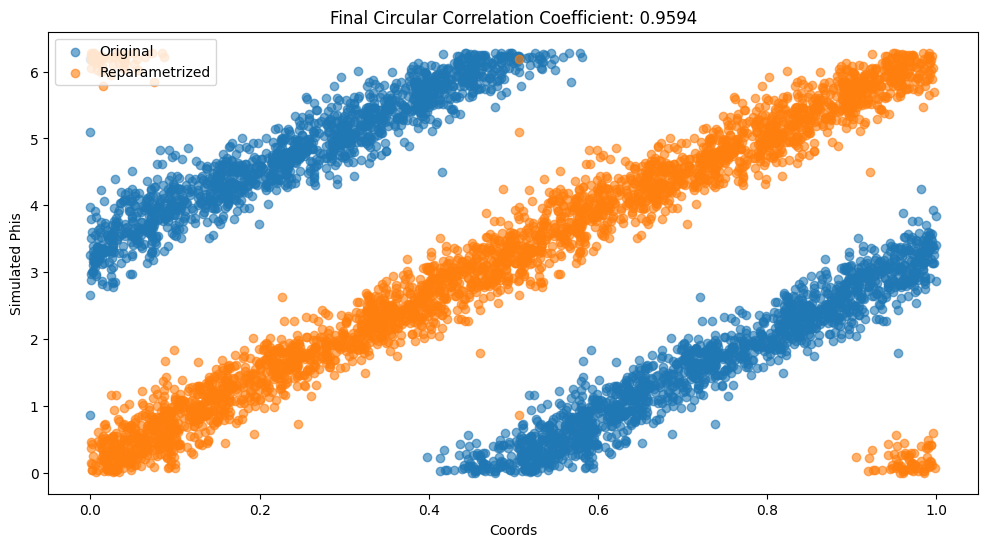

Final circular correlation coefficient: 0.9593629481821497


0.9593629481821497

In [25]:
# Simulate the data
adata = simulate_data(Nc=3000, Ng=350)
adata.var['sim_sin'] = adata.uns['simulated_nu'][:,:,1]
adata.var['sim_cos'] = adata.uns['simulated_nu'][:,:,2]

adata = create_spliced_unspliced_adata(adata)

adata_velocycle = adata.copy()

# Apply standard normalization
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log transform the data and scale
sc.pp.log1p(adata)

# Diffusion and filtering for highly variable genes
# sce.pp.magic(adata, knn=10, t=6, random_state=RANDOM_STATE, n_jobs=4)
# sc.pp.highly_variable_genes(adata, subset=True)

# PCA
sc.pp.pca(adata, n_comps=5, random_state=RANDOM_STATE)

# Calculate the diameter and ratio scores
diam_score = chnt.ring_score(adata, score_type='diameter', exponent=2, comp=np.arange(5))
ratio_score = chnt.ring_score(adata, score_type='ratio', exponent=2, comp=np.arange(5))

# Calculate the circular correlation
chnt.circular(adata, comp = [0,1])
compute_final_circular_corrcoef_with_plotting(adata)

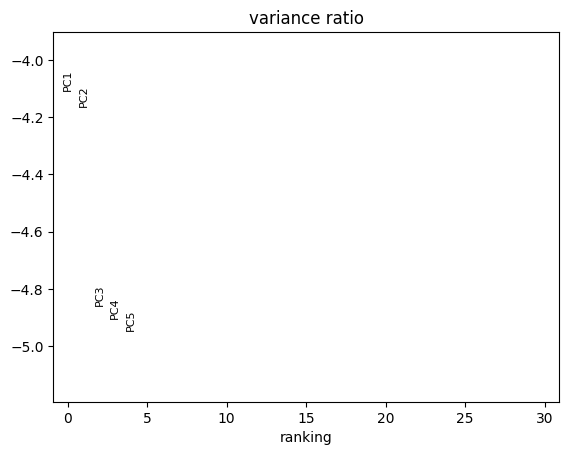

In [77]:
sc.pl.pca_variance_ratio(adata, log=True)

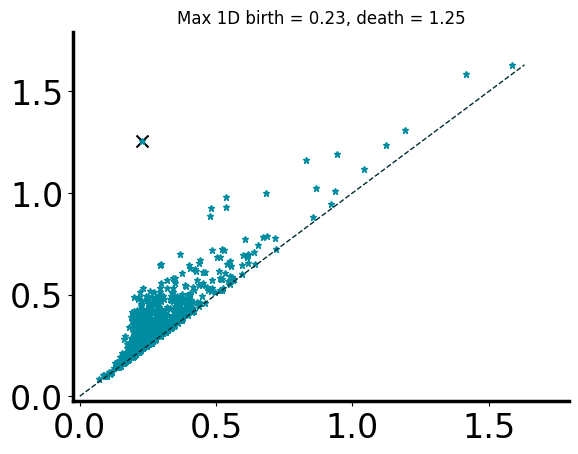

In [8]:
chnt.plot_diagram(adata, comp = [0,1])

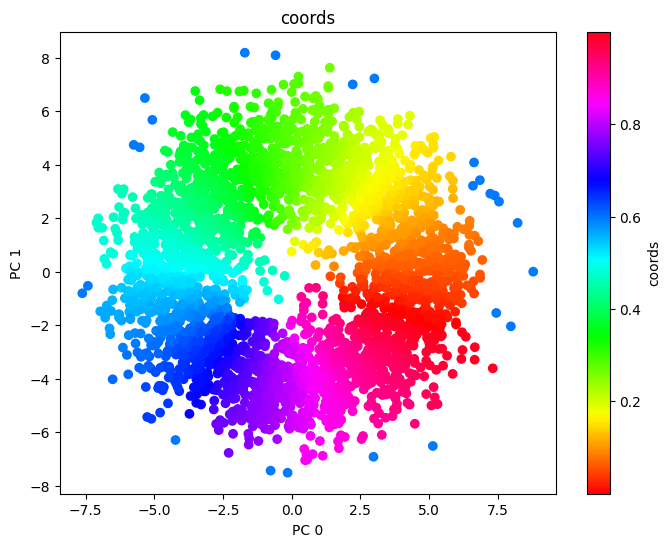

In [9]:
chnt.plot_2d(adata, comp = [0,1], mode = 'pca', c = 'coords')

In [21]:
adata_hvg = adata[:,:350]

In [12]:
# subset adata by highly variable genes
sc.pp.highly_variable_genes(adata)
adata_hvg = adata[:, adata.var['highly_variable']]
adata_hvg

View of AnnData object with n_obs × n_vars = 3000 × 160
    obs: 'batch', 'simulated_omega', 'simulated_phis', 'n_counts', 'coords', 'log_counts'
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas', 'sim_sin', 'sim_cos', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'simulated_ζ', 'simulated_ζ_dφ', 'simulated_nu', 'log1p', 'pca', 'pdgm', 'circular', 'hvg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'h_recenter'

In [22]:
chnt.leadlag(adata_hvg)

Harmonic Recentering
Calculating Leadlag Matrix


 65%|██████▍   | 227/350 [29:53<16:11,  7.90s/it] 


KeyboardInterrupt: 

/Users/kelly/Downloads/chunter.py:1163: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp.values.real, exp.values.imag, s = amps*200, c = plt.cm.hsv(np.angle(exp.values) % (2*np.pi) / (2 * np.pi)), cmap = 'hsv', edgecolors = 'black', alpha = 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


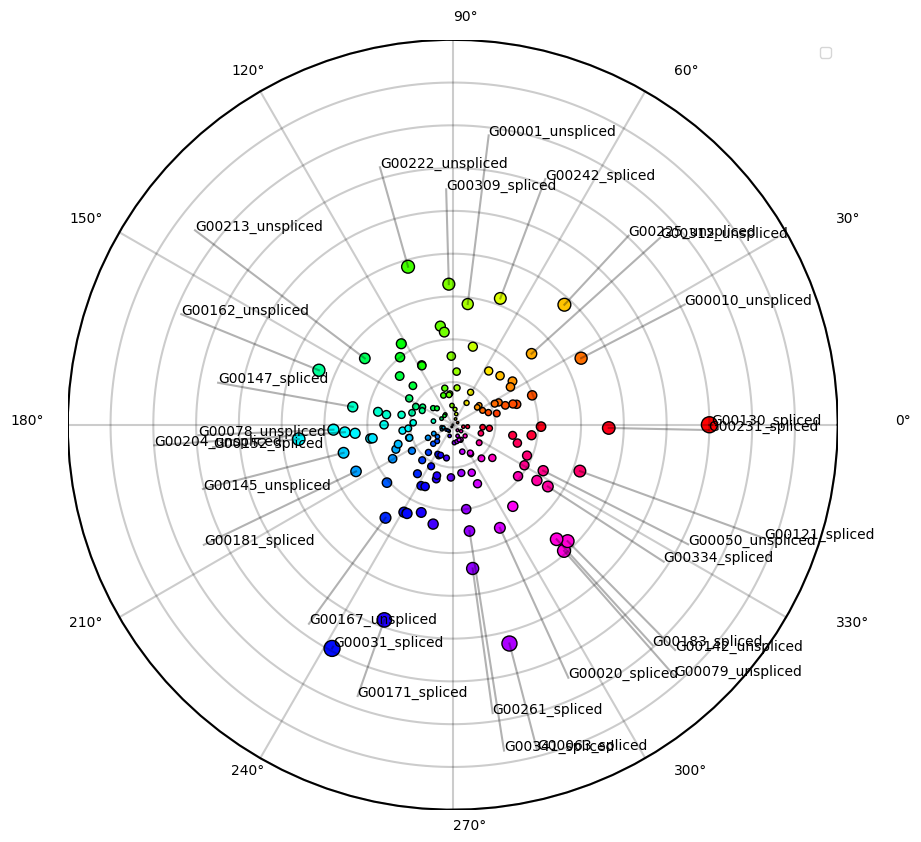

In [15]:
chnt.phase_plot(adata_hvg, topk=30)

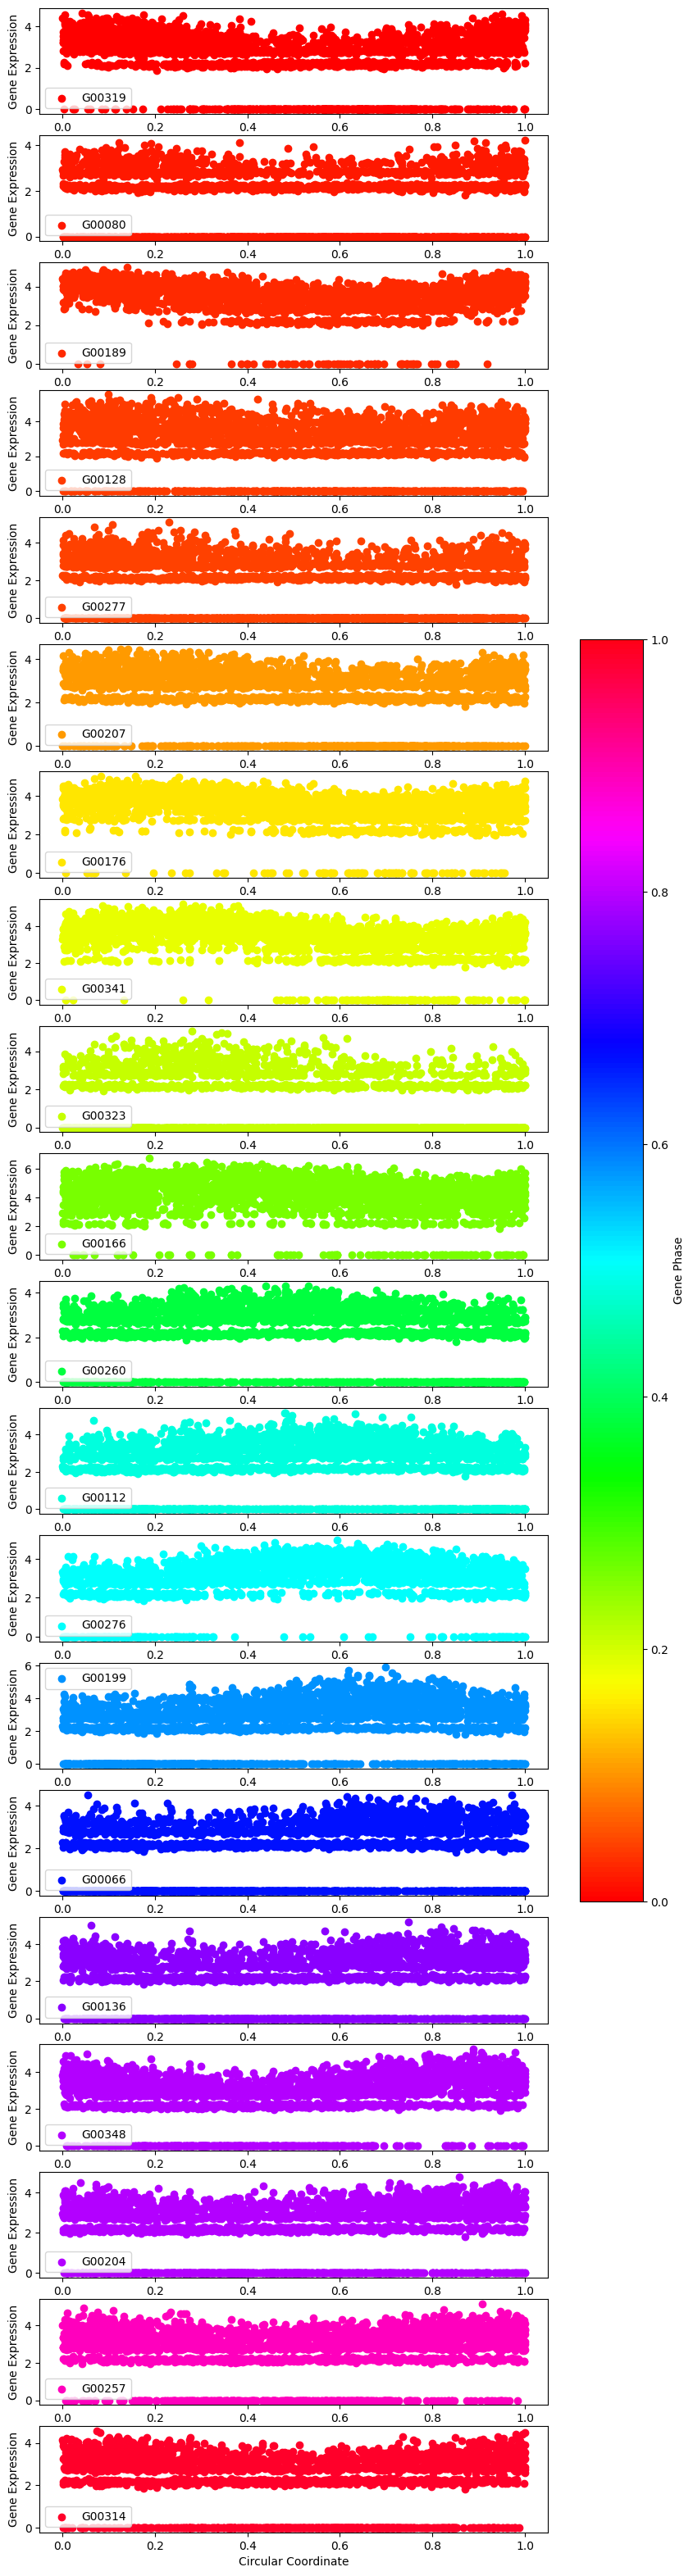

In [84]:
chnt.plot_top_genes(adata, k = 20)

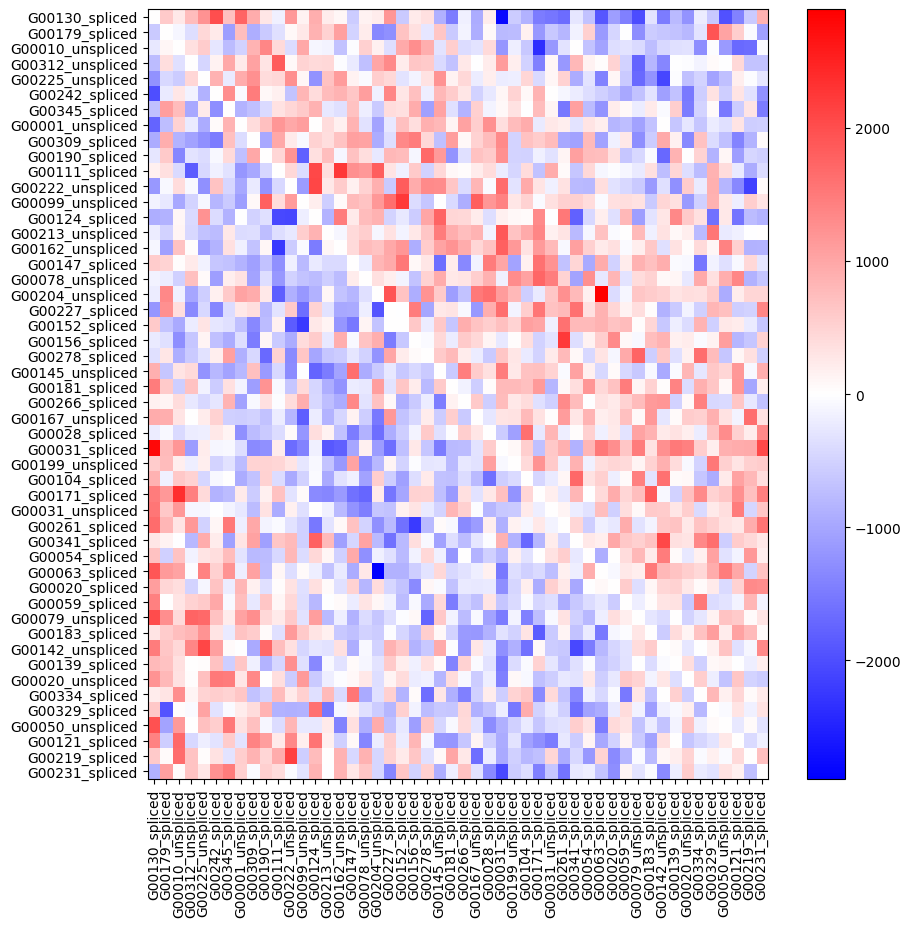

In [16]:
chnt.leadlag_plot(adata_hvg, k = 50)

Text(0, 0.5, 'Simulated sine')

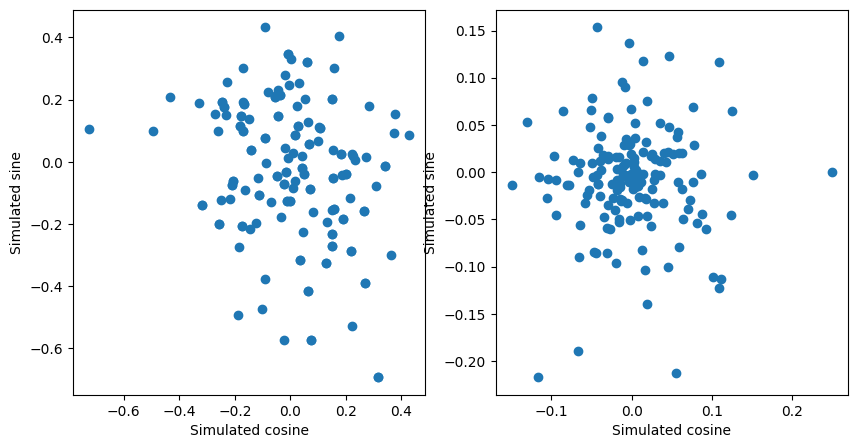

In [17]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

# first plot
plt.sca(ax[0])
plt.scatter(adata_hvg.var['sim_cos'], adata_hvg.var['sim_sin'])
plt.xlabel('Simulated cosine')
plt.ylabel('Simulated sine')


# second plot
plt.sca(ax[1])
plt.scatter(np.real(adata_hvg.varm['leadlag_pcs'][:,0]),np.imag(adata_hvg.varm['leadlag_pcs'][:,0]))
plt.xlabel('Simulated cosine')
plt.ylabel('Simulated sine')


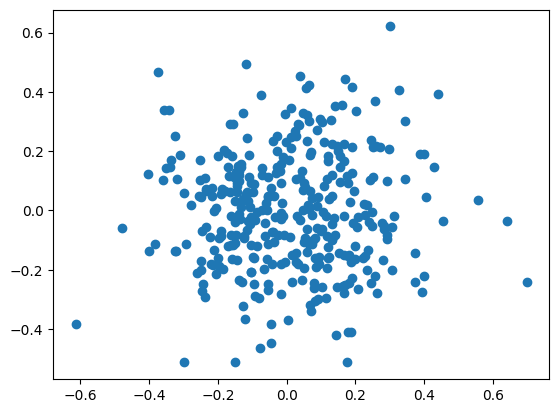

In [87]:
plt.scatter(adata.var['sim_sin'], adata.var['sim_cos'])

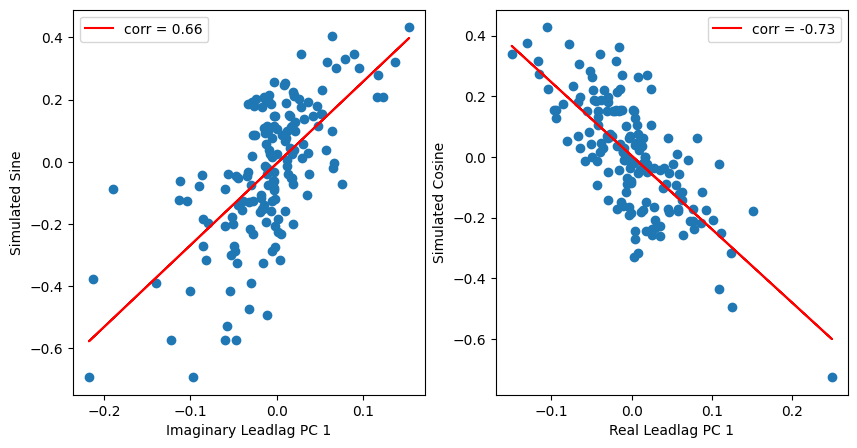

In [18]:
# redo the previous two plots as subplots of a bigger plot
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# plot the first subplot
plt.sca(axs[0])

# calculate the correlation between the leadlag pcs and the simulated nu
corr = np.corrcoef(np.imag(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_sin'])[0,1]

# add corr as a legend
plt.scatter(np.imag(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_sin'])

# label x axis
plt.xlabel('Imaginary Leadlag PC 1')

# label y axis
plt.ylabel('Simulated Sine')

# plot line of best fit
plt.plot(np.imag(adata_hvg.varm['leadlag_pcs'][:,0]), np.polyval(np.polyfit(np.imag(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_sin'], 1), np.imag(adata_hvg.varm['leadlag_pcs'][:,0])), color = 'red', label = f'corr = {corr:.2f}')
         
plt.legend()

# plot the second subplot
plt.sca(axs[1])

# calculate the correlation between the leadlag pcs and the simulated nu
corr = np.corrcoef(np.real(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_cos'])[0,1]

# add corr as a legend
plt.scatter(np.real(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_cos'])

# label x axis
plt.xlabel('Real Leadlag PC 1')

# label y axis
plt.ylabel('Simulated Cosine')

# plot line of best fit
plt.plot(np.real(adata_hvg.varm['leadlag_pcs'][:,0]), np.polyval(np.polyfit(np.real(adata_hvg.varm['leadlag_pcs'][:,0]), adata_hvg.var['sim_cos'], 1), np.real(adata_hvg.varm['leadlag_pcs'][:,0])), color = 'red', label = f'corr = {corr:.2f}')

plt.legend()

plt.show()


In [89]:
top_genes = chnt.get_top_genes(adata, k = 10)

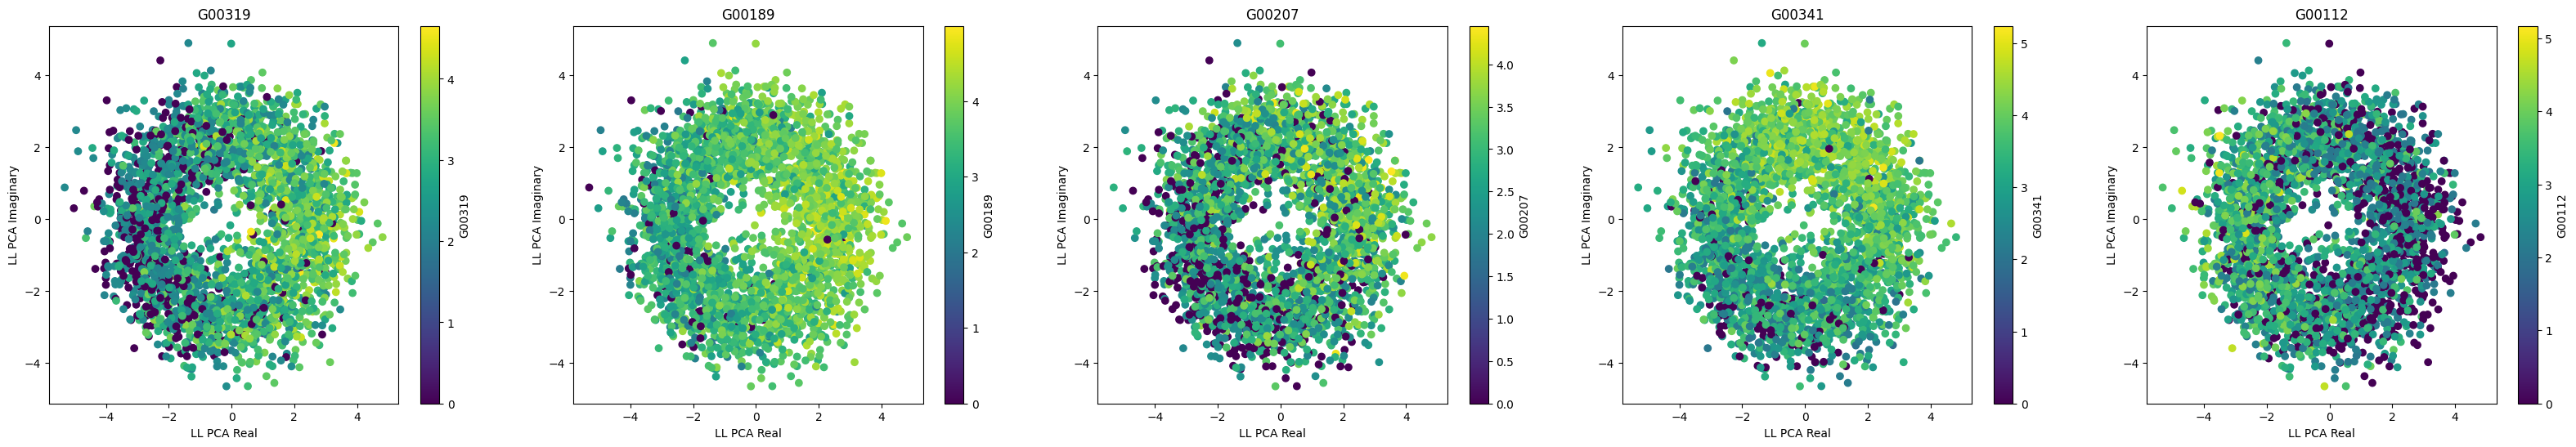

In [90]:
chnt.plot_2d(adata, c = top_genes[:5], mode = 'll')

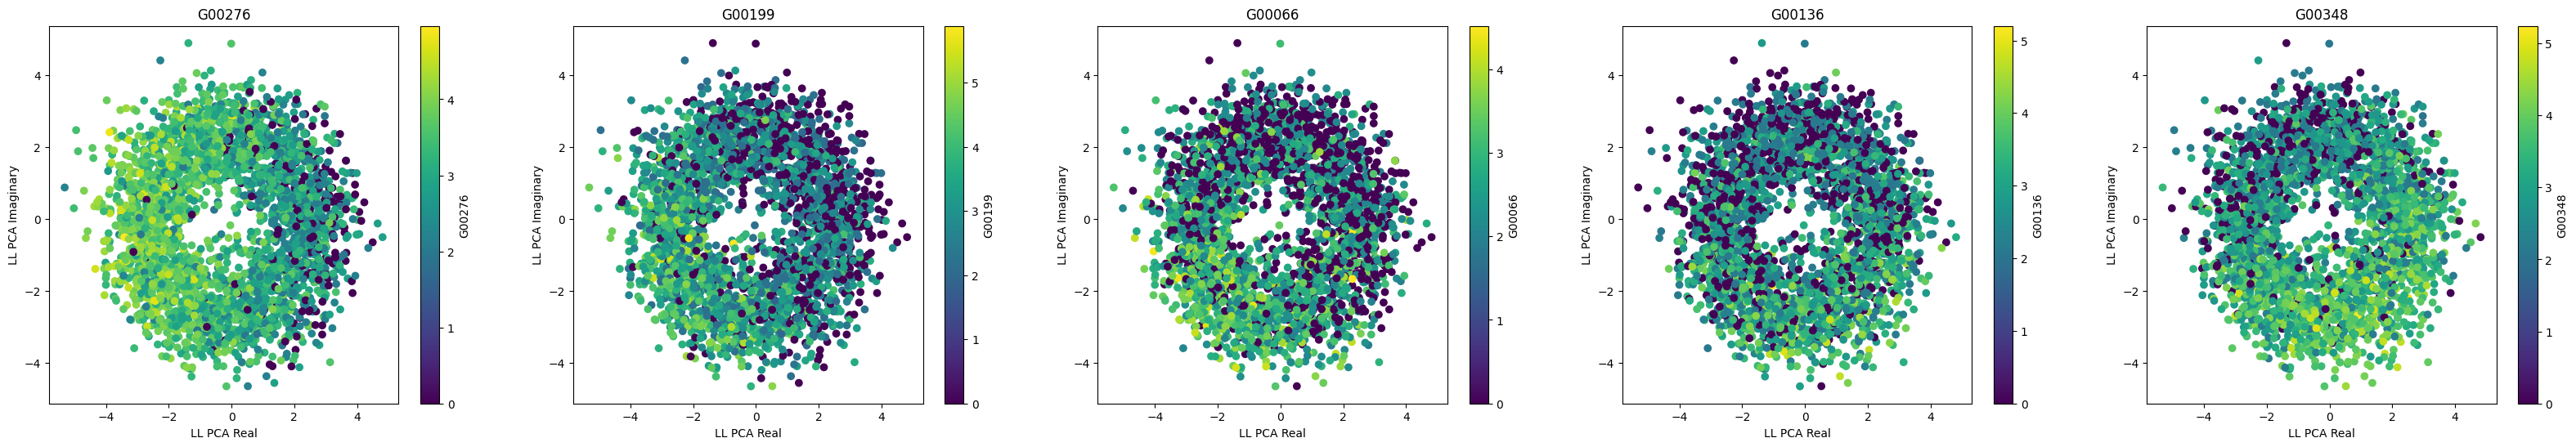

In [91]:
chnt.plot_2d(adata, c = top_genes[5:], mode = 'll')

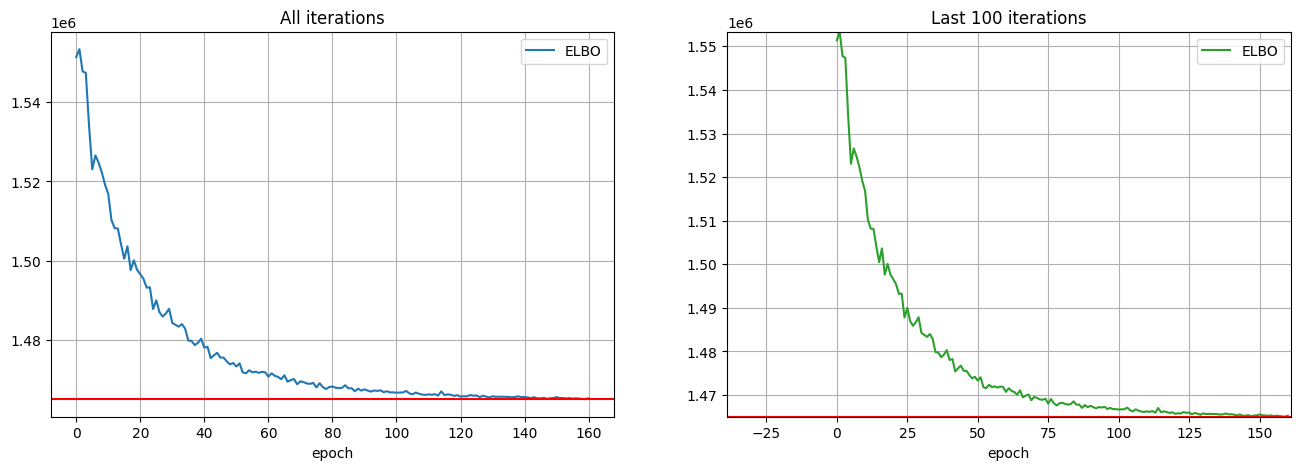

Prior circular correlation coefficient:  0.924261075603505
Initial circular correlation coefficient: 0.9242610731993766


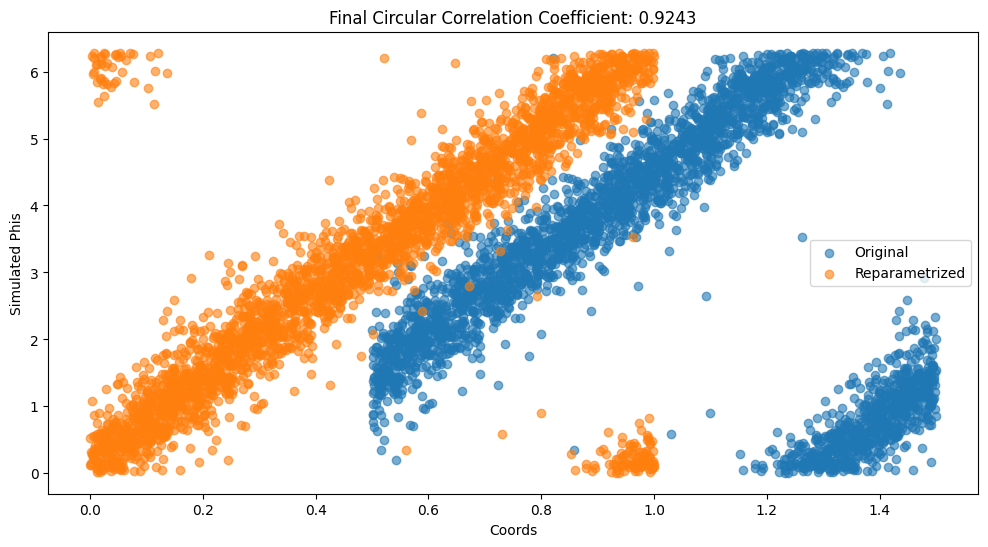

Final circular correlation coefficient: 0.924261075603505
0.10297179222106934
Prior circular correlation coefficient:  0.03331800057938866
Initial circular correlation coefficient: 0.03331800057938866


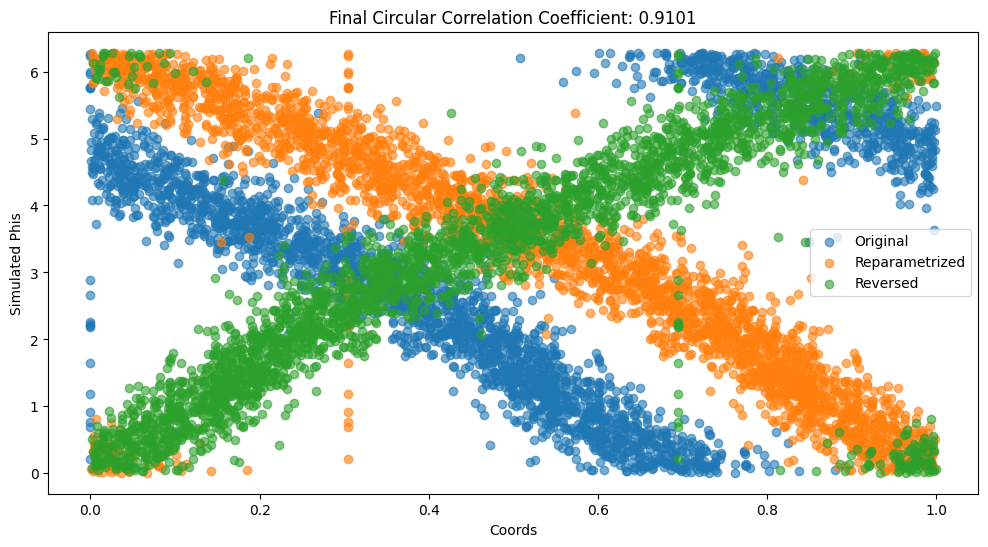

Final circular correlation coefficient: 0.9101036280092565
Prior circular correlation coefficient:  0.027946117303047247
Initial circular correlation coefficient: 0.02794613596800809


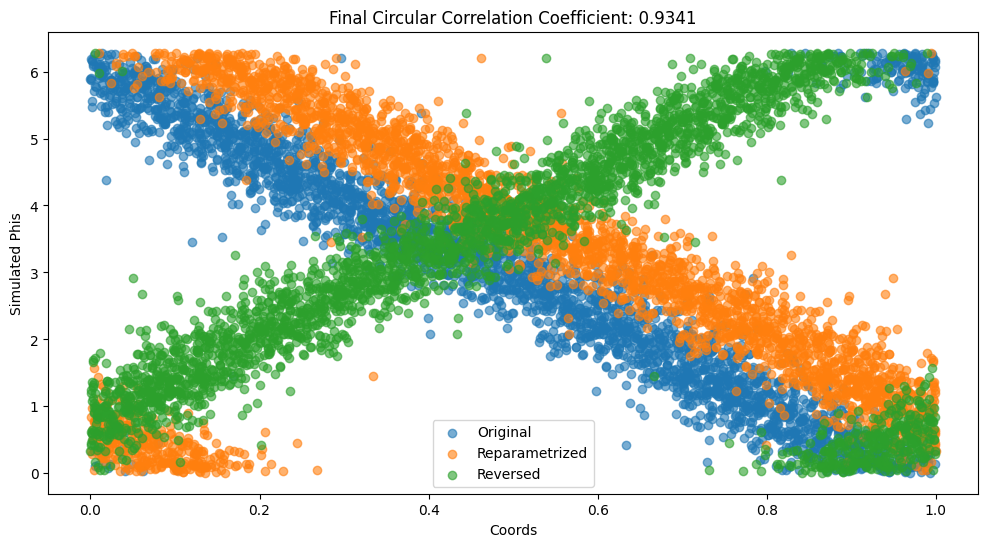

Final circular correlation coefficient: 0.9340510797094863


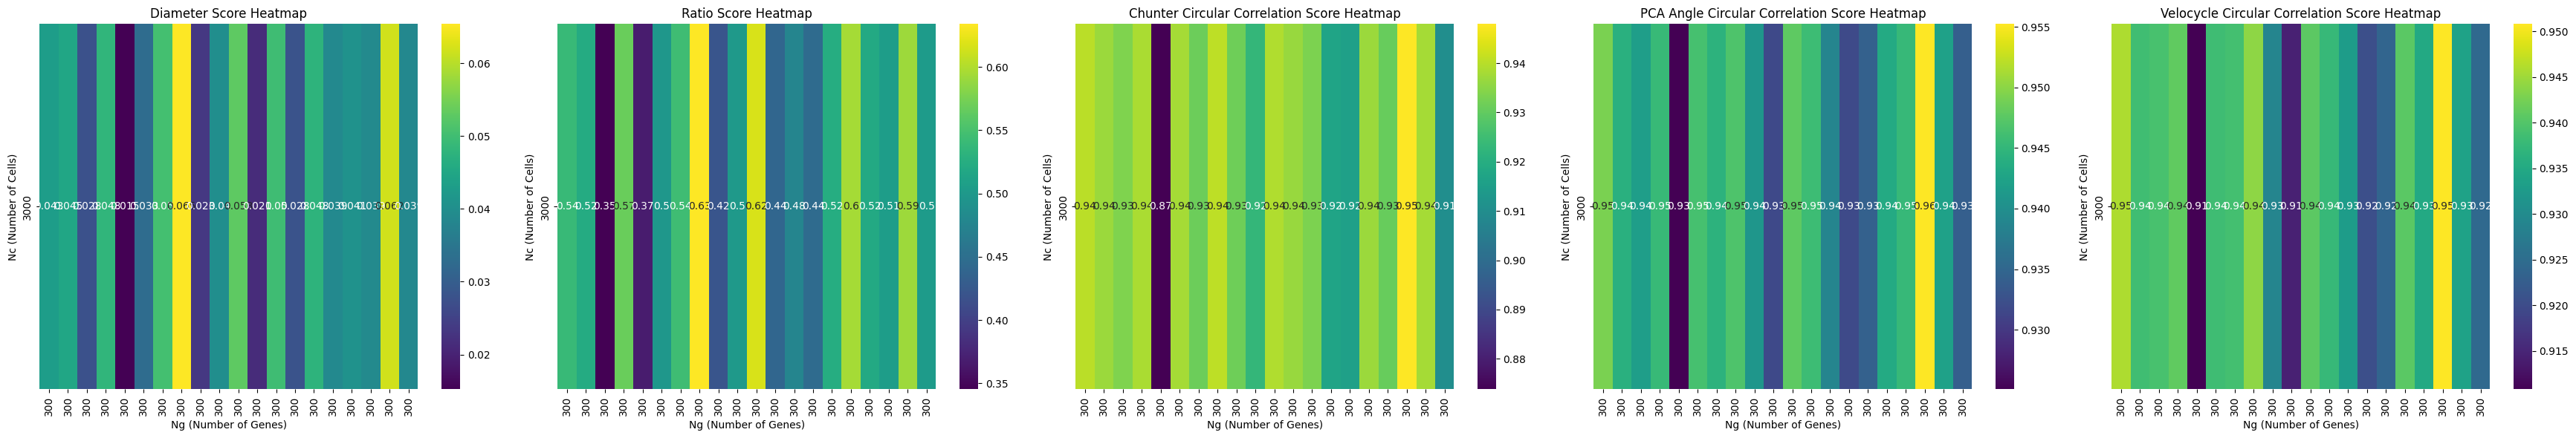

In [85]:
# Define the ranges for Nc and Ng
#Ng_values = [100, 200, 350, 500, 750, 1000]
#Nc_values = [100, 200, 500, 1000, 3000]

Ng_values = [300]*20
Nc_values = [3000]


# Initialize arrays to hold the scores
diam_scores = np.zeros((len(Nc_values), len(Ng_values)))
ratio_scores = np.zeros((len(Nc_values), len(Ng_values)))
circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
pca_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))
velocycle_circ_correlation = np.zeros((len(Nc_values), len(Ng_values)))

# Loop over the different values of Nc and Ng
for i, Nc in enumerate(Nc_values):
    for j, Ng in enumerate(Ng_values):
        print(f'Nc: {Nc}, Ng: {Ng}')
        # Simulate the data
        adata = simulate_data(Nc=Nc, Ng=Ng)

        velocycle_adata = velocycle_estimation(adata)
        velocycle_circ_correlation[i,j] = compute_final_circular_corrcoef_with_plotting(velocycle_adata)
        

        adata.var['sim_sin'] = adata.uns['simulated_nu'][:,:,1]
        adata.var['sim_cos'] = adata.uns['simulated_nu'][:,:,2]

        adata = create_spliced_unspliced_adata(adata)

        # Apply standard normalization
        sc.pp.filter_genes(adata, min_cells=3)
        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

        # Log transform the data and scale
        sc.pp.log1p(adata)

        # Diffusion and filtering for highly variable genes
        # sce.pp.magic(adata, knn=10, t=2, random_state=RANDOM_STATE, n_jobs=4)
        # sc.pp.highly_variable_genes(adata, subset=True)

        # PCA
        sc.pp.pca(adata, n_comps=2, use_highly_variable=False, random_state=RANDOM_STATE)

        # Calculate the diameter and ratio scores
        diam_score = chnt.ring_score(adata, score_type='diameter', exponent=2, comp=np.arange(2))
        ratio_score = chnt.ring_score(adata, score_type='ratio', exponent=2, comp=np.arange(2))

        # Store the results
        diam_scores[i, j] = diam_score
        ratio_scores[i, j] = ratio_score
        
        # Calculate the circular correlation
        chnt.circular(adata, comp = [0,1])
        circ_correlation[i,j] = compute_final_circular_corrcoef_with_plotting(adata)

        angles = np.arctan2(adata.obsm['X_pca'][:, 0], adata.obsm['X_pca'][:, 1])
        pca_adata = adata.copy()
        pca_adata.obs['coords'] = ( angles + np.pi) / (2 * np.pi)
        pca_circ_correlation[i,j] = compute_final_circular_corrcoef_with_plotting(pca_adata)

# Plot the results as heatmaps
fig, axes = plt.subplots(1, 5, figsize=(35, 6))

sns.heatmap(diam_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[0], cmap='viridis', annot = True)
axes[0].set_title('Diameter Score Heatmap')
axes[0].set_xlabel('Ng (Number of Genes)')
axes[0].set_ylabel('Nc (Number of Cells)')

sns.heatmap(ratio_scores, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[1], cmap='viridis', annot = True)
axes[1].set_title('Ratio Score Heatmap')
axes[1].set_xlabel('Ng (Number of Genes)')
axes[1].set_ylabel('Nc (Number of Cells)')

sns.heatmap(circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[2], cmap='viridis', annot = True)
axes[2].set_title('Chunter Circular Correlation Score Heatmap')
axes[2].set_xlabel('Ng (Number of Genes)')
axes[2].set_ylabel('Nc (Number of Cells)')

sns.heatmap(pca_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[3], cmap='viridis', annot = True)
axes[3].set_title('PCA Angle Circular Correlation Score Heatmap')
axes[3].set_xlabel('Ng (Number of Genes)')
axes[3].set_ylabel('Nc (Number of Cells)')

sns.heatmap(velocycle_circ_correlation, xticklabels=Ng_values, yticklabels=Nc_values, ax=axes[4], cmap='viridis', annot = True)
axes[4].set_title('Velocycle Circular Correlation Score Heatmap')
axes[4].set_xlabel('Ng (Number of Genes)')
axes[4].set_ylabel('Nc (Number of Cells)')

plt.tight_layout()
plt.show()

In [114]:
chunter_coords = adata.obs['coords']

pca_coords = (pca_adata.obs['coords']+0.1) % 1

velocycle_coords = velocycle_adata.obs['coords']

simulated_coords = adata.obs['simulated_phis'] / (2*np.pi)


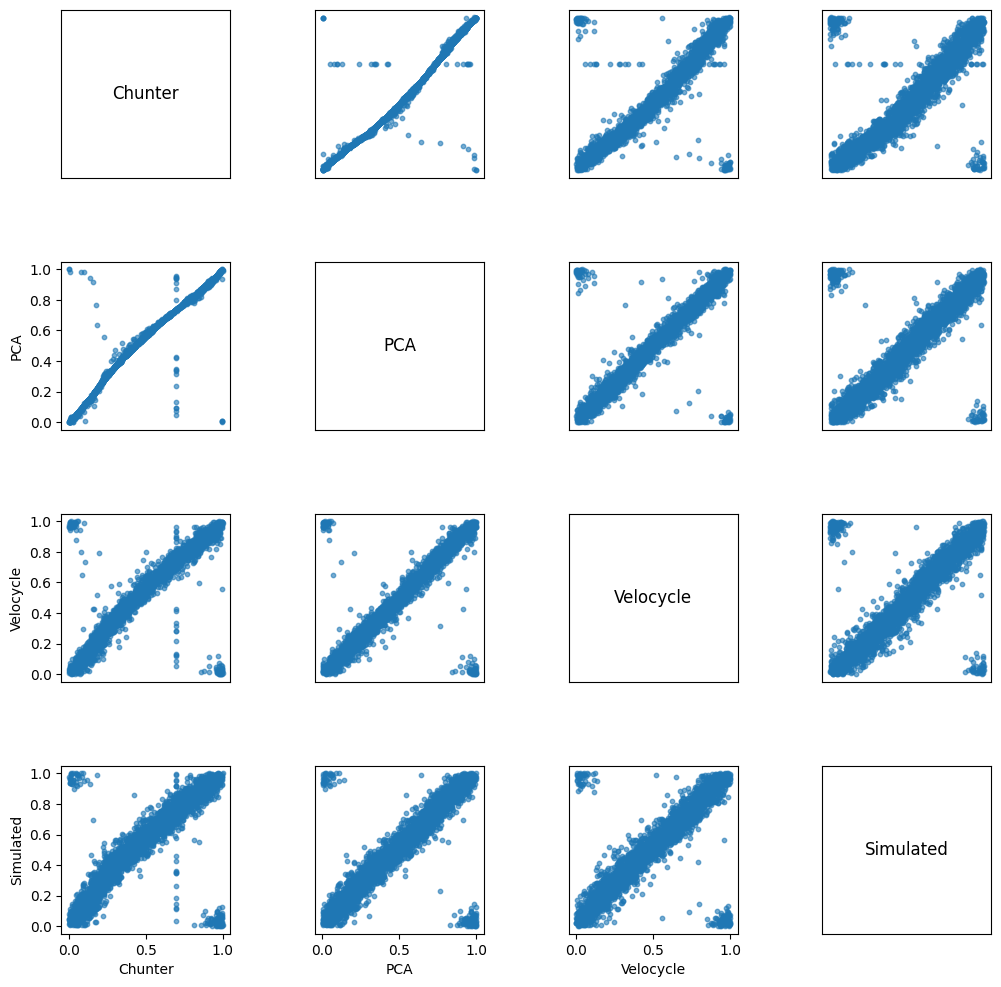

In [115]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_pairwise_scatter(chunter_coords, pca_coords, velocycle_coords, simulated_coords):
    """
    Creates a 4x4 matrix of pairwise scatter plots between four sets of coordinates.
    
    Parameters:
    chunter_coords (pd.Series): Coordinates from chunter.
    pca_coords (pd.Series): Coordinates from PCA.
    velocycle_coords (pd.Series): Coordinates from velocycle.
    simulated_coords (pd.Series): Simulated coordinates.

    Returns:
    None: Displays the scatter plot matrix.
    """
    # Combine the coordinates into a DataFrame for easier iteration
    data = pd.DataFrame({
        'Chunter': chunter_coords,
        'PCA': pca_coords,
        'Velocycle': velocycle_coords,
        'Simulated': simulated_coords
    })
    
    labels = data.columns
    num_coords = len(labels)

    # Set up a 4x4 grid for pairwise scatter plots
    fig, axes = plt.subplots(num_coords, num_coords, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    

    for i in range(num_coords):
        for j in range(num_coords):
            ax = axes[i, j]
            
            if i == j:
                # Diagonal plots: show the variable name
                ax.text(0.5, 0.5, labels[i], fontsize=12, ha='center', va='center')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                # Scatter plots for off-diagonal pairs
                ax.scatter(data.iloc[:, j], data.iloc[:, i], alpha=0.6, s=10)
                if j == 0:
                    ax.set_ylabel(labels[i])
                else:
                    ax.set_yticks([])
                if i == num_coords - 1:
                    ax.set_xlabel(labels[j])
                else:
                    ax.set_xticks([])



    plt.show()

plot_pairwise_scatter(chunter_coords, pca_coords, velocycle_coords, simulated_coords)


In [116]:
adata

AnnData object with n_obs × n_vars = 3000 × 600
    obs: 'batch', 'simulated_omega', 'simulated_phis', 'n_counts', 'coords', 'log_counts'
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas', 'sim_sin', 'sim_cos', 'n_cells'
    uns: 'simulated_ζ', 'simulated_ζ_dφ', 'simulated_nu', 'log1p', 'pca', 'pdgm', 'circular'
    obsm: 'X_pca'
    varm: 'PCs'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


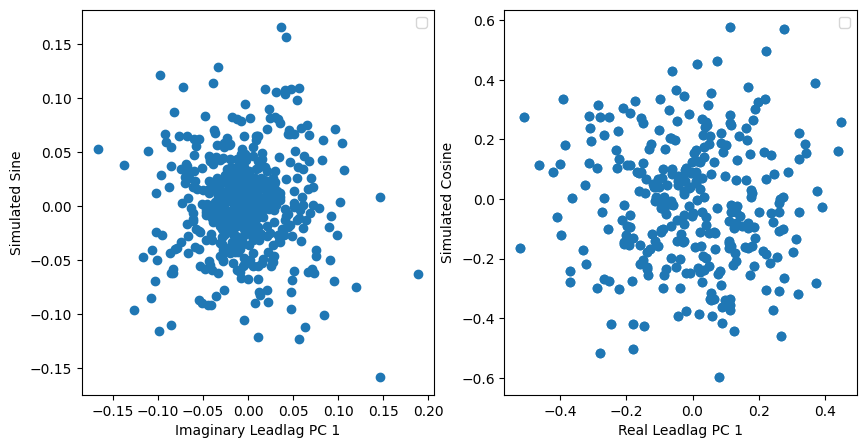

In [127]:
# redo the previous two plots as subplots of a bigger plot
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

# plot the first subplot
plt.sca(axs[0])

# calculate the correlation between the leadlag pcs and the simulated nu
corr = np.corrcoef(adata.varm['PCs'][:,0], adata.var['sim_sin'])[0,1]

# add corr as a legend
plt.scatter(adata.varm['PCs'][:,0], adata.varm['PCs'][:,1])

# label x axis
plt.xlabel('Imaginary Leadlag PC 1')

# label y axis
plt.ylabel('Simulated Sine')

plt.legend()

# plot the second subplot
plt.sca(axs[1])

# calculate the correlation between the leadlag pcs and the simulated nu
corr = np.corrcoef(adata.var['sim_cos'], adata.var['sim_sin'])[0,1]

# add corr as a legend
plt.scatter(adata.var['sim_cos'], adata.var['sim_sin'])

# label x axis
plt.xlabel('Real Leadlag PC 1')

# label y axis
plt.ylabel('Simulated Cosine')

plt.legend()

plt.show()

In [132]:
ll_adata = chnt.leadlag(adata[:,:300])

Harmonic Recentering
Calculating Leadlag Matrix


100%|██████████| 300/300 [25:10<00:00,  5.04s/it]


Calculating Spectral Information
Estimated starting gene:  G00204_spliced
Phase correction:  6.179222785410926 rad


/Users/kelly/Downloads/chunter.py:1163: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(exp.values.real, exp.values.imag, s = amps*200, c = plt.cm.hsv(np.angle(exp.values) % (2*np.pi) / (2 * np.pi)), cmap = 'hsv', edgecolors = 'black', alpha = 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


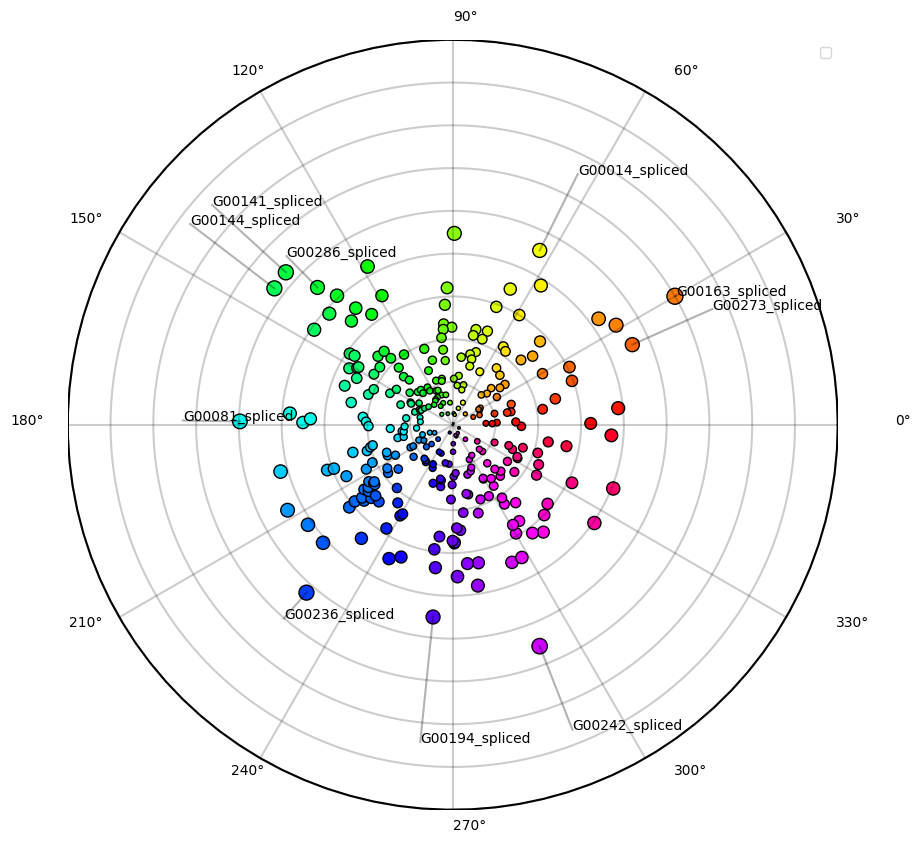

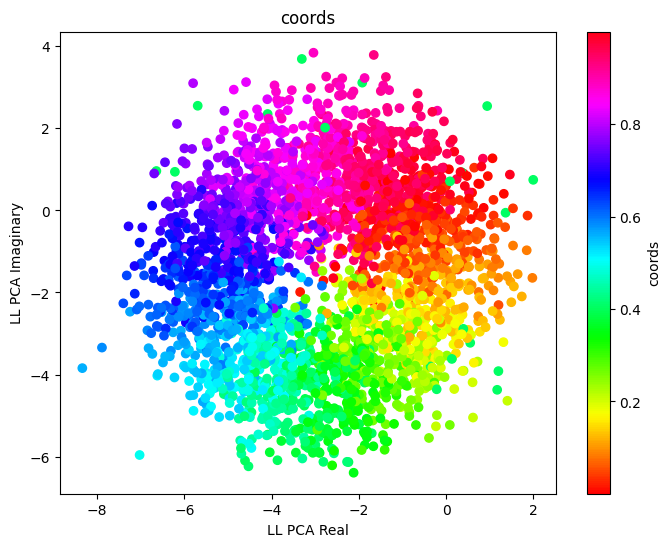

AnnData object with n_obs × n_vars = 3000 × 300
    obs: 'batch', 'simulated_omega', 'simulated_phis', 'n_counts', 'coords', 'log_counts'
    var: 'simulated_shape_inv', 'simulated_gammas', 'simulated_betas', 'sim_sin', 'sim_cos', 'n_cells', 'gene_phase', 'gene_amp'
    uns: 'simulated_ζ', 'simulated_ζ_dφ', 'simulated_nu', 'log1p', 'pca', 'pdgm', 'circular', 'leadlag', 'leadlag_eigvals'
    obsm: 'X_pca'
    varm: 'PCs', 'leadlag_pcs'
    layers: 'h_recenter'

In [144]:
chnt.reverse(ll_adata)

<Figure size 1000x600 with 0 Axes>

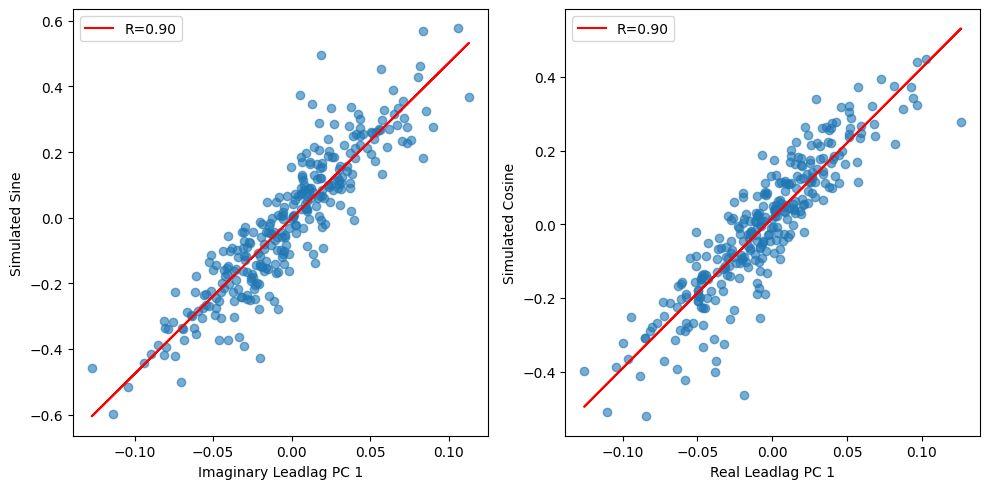

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# initialize plot
plt.figure(figsize=(10, 6))

# make two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Extract data for plots
imag_pc1 = np.imag(ll_adata.varm['leadlag_pcs'][:, 0])
real_pc1 = np.real(ll_adata.varm['leadlag_pcs'][:, 0])
sim_sin = ll_adata.var['sim_sin']
sim_cos = ll_adata.var['sim_cos']

# Calculate correlations and fit lines for plot 0
corr1, p_value1 = np.corrcoef(imag_pc1, sim_sin)[0, 1], None
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(imag_pc1, sim_sin)
line1 = slope1 * imag_pc1 + intercept1

# Calculate correlations and fit lines for plot 1
corr2, p_value2 = np.corrcoef(real_pc1, sim_cos)[0, 1], None
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(real_pc1, sim_cos)
line2 = slope2 * real_pc1 + intercept2

# Plot the leadlag PC 0 against sim_sin
ax[0].scatter(imag_pc1, sim_sin, alpha=0.6)
ax[0].plot(imag_pc1, line1, color='red', label=f"R={corr1:.2f}")
ax[0].set_xlabel('Imaginary Leadlag PC 1')
ax[0].set_ylabel('Simulated Sine')
ax[0].legend()

# Plot the leadlag PC 0 against sim_cos
ax[1].scatter(real_pc1, sim_cos, alpha=0.6)
ax[1].plot(real_pc1, line2, color='red', label=f"R={corr2:.2f}")
ax[1].set_xlabel('Real Leadlag PC 1')
ax[1].set_ylabel('Simulated Cosine')
ax[1].legend()

# Display the plot
plt.tight_layout()
plt.show()


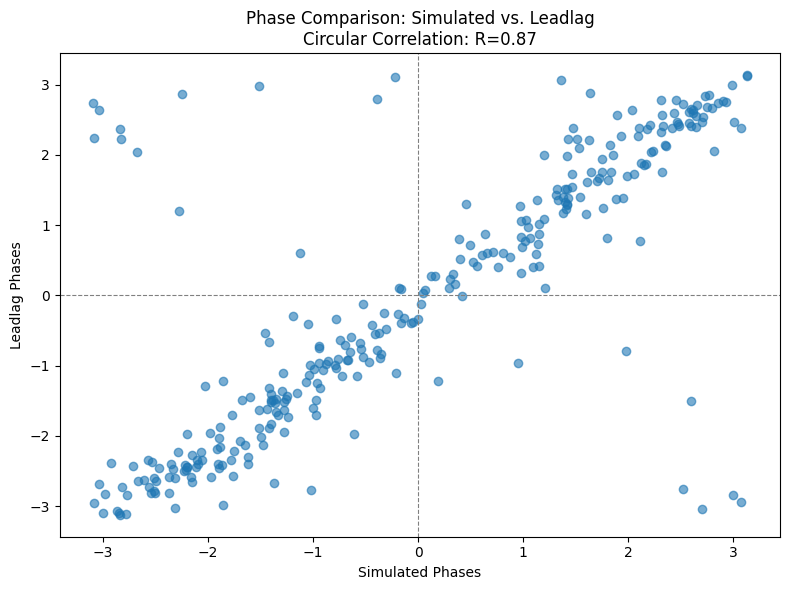

In [204]:
# Extract the complex vectors
leadlag_pcs = ll_adata.varm['leadlag_pcs'][:, 0]
sim_vector = ll_adata.var['sim_cos'] + 1j * ll_adata.var['sim_sin']

# Calculate the phases (angles) of the complex vectors
leadlag_phases = np.angle(leadlag_pcs)
sim_phases = np.angle(sim_vector)

# Compute the circular correlation coefficient
circular_corr = circular_corrcoef(leadlag_phases, sim_phases)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sim_phases, leadlag_phases, alpha=0.6)

# Add labels and title
plt.xlabel('Simulated Phases')
plt.ylabel('Leadlag Phases')
plt.title(f'Phase Comparison: Simulated vs. Leadlag\nCircular Correlation: R={circular_corr:.2f}')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Display the plot
plt.tight_layout()
plt.show()

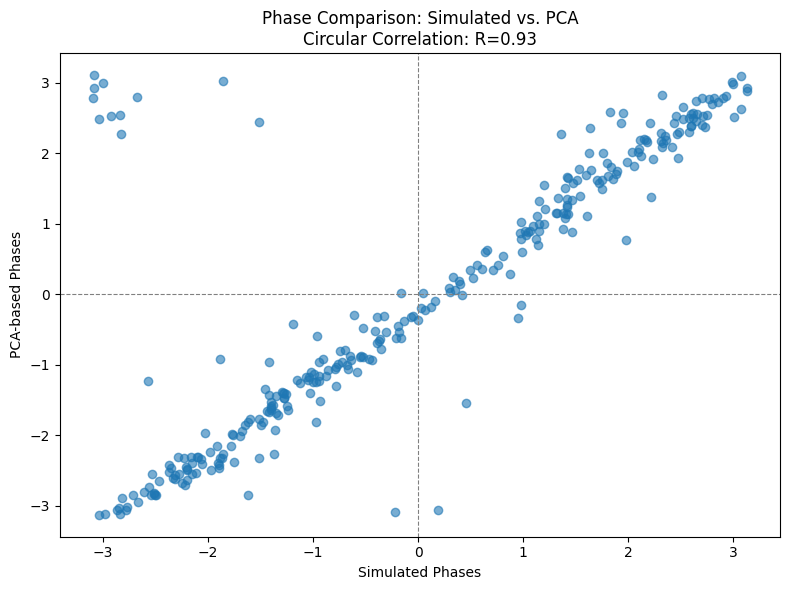

In [203]:
# Extract the complex vectors
leadlag_pcs = ll_adata.varm['leadlag_pcs'][:, 0]
pcs = ll_adata.varm['PCs'][:, 0] + 1j * ll_adata.varm['PCs'][:, 1]
sim_vector = ll_adata.var['sim_cos'] + 1j * ll_adata.var['sim_sin']

# Calculate the phases (angles) of the complex vectors
leadlag_phases = np.angle(np.exp(1.1j) * pcs)
sim_phases = np.angle(sim_vector)

# Compute the circular correlation coefficient
circular_corr = circular_corrcoef(leadlag_phases, sim_phases)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sim_phases, leadlag_phases, alpha=0.6)

# Add labels and title
plt.xlabel('Simulated Phases')
plt.ylabel('PCA-based Phases')
plt.title(f'Phase Comparison: Simulated vs. PCA\nCircular Correlation: R={circular_corr:.2f}')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Display the plot
plt.tight_layout()
plt.show()

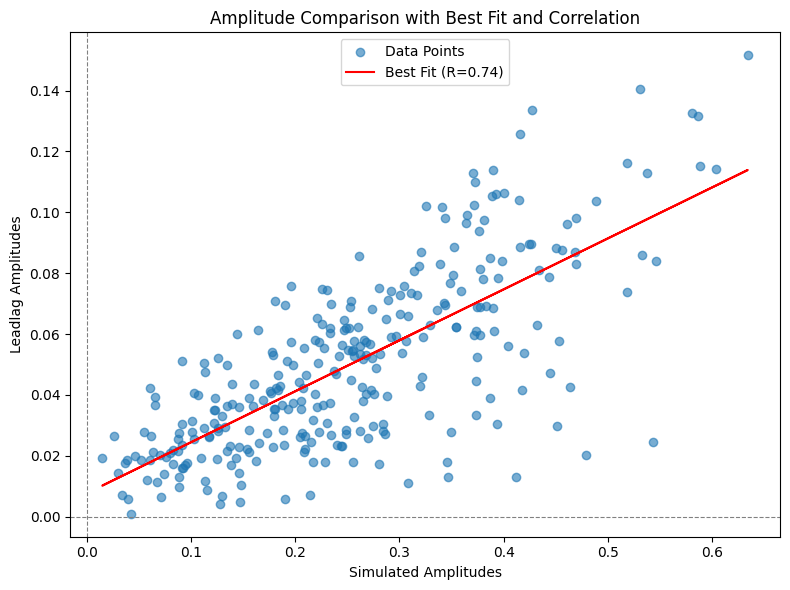

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Extract the complex vectors
leadlag_pcs = ll_adata.varm['leadlag_pcs'][:, 0]
sim_vector = ll_adata.var['sim_cos'] + 1j * ll_adata.var['sim_sin']

# Calculate the amplitudes (magnitudes) of the complex vectors
leadlag_amplitudes = np.abs(leadlag_pcs)
sim_amplitudes = np.abs(sim_vector)

# Calculate the line of best fit and correlation coefficient
slope, intercept, r_value, p_value, std_err = linregress(sim_amplitudes, leadlag_amplitudes)
line_of_best_fit = slope * sim_amplitudes + intercept
correlation_coefficient = r_value

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sim_amplitudes, leadlag_amplitudes, alpha=0.6, label='Data Points')

# Plot the line of best fit
plt.plot(sim_amplitudes, line_of_best_fit, color='red', label=f'Best Fit (R={correlation_coefficient:.2f})')

# Add labels and title
plt.xlabel('Simulated Amplitudes')
plt.ylabel('Leadlag Amplitudes')
plt.title('Amplitude Comparison with Best Fit and Correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


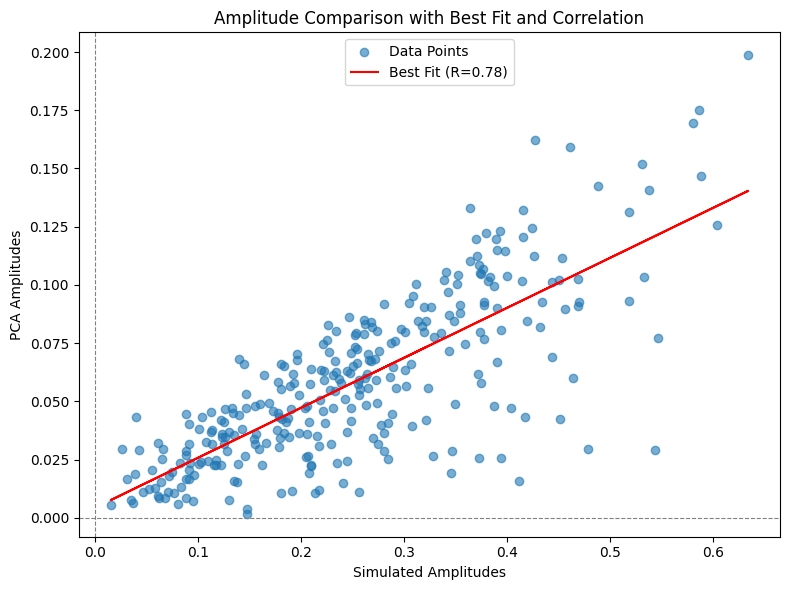

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Extract the complex vectors
leadlag_pcs =ll_adata.varm['PCs'][:, 0] + 1j * ll_adata.varm['PCs'][:, 1]
sim_vector = ll_adata.var['sim_cos'] + 1j * ll_adata.var['sim_sin']

# Calculate the amplitudes (magnitudes) of the complex vectors
leadlag_amplitudes = np.abs(leadlag_pcs)
sim_amplitudes = np.abs(sim_vector)

# Calculate the line of best fit and correlation coefficient
slope, intercept, r_value, p_value, std_err = linregress(sim_amplitudes, leadlag_amplitudes)
line_of_best_fit = slope * sim_amplitudes + intercept
correlation_coefficient = r_value

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sim_amplitudes, leadlag_amplitudes, alpha=0.6, label='Data Points')

# Plot the line of best fit
plt.plot(sim_amplitudes, line_of_best_fit, color='red', label=f'Best Fit (R={correlation_coefficient:.2f})')

# Add labels and title
plt.xlabel('Simulated Amplitudes')
plt.ylabel('PCA Amplitudes')
plt.title('Amplitude Comparison with Best Fit and Correlation')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [195]:
cycle_pyro.genes

['G00000',
 'G00001',
 'G00002',
 'G00003',
 'G00004',
 'G00005',
 'G00006',
 'G00007',
 'G00008',
 'G00009',
 'G00010',
 'G00011',
 'G00012',
 'G00013',
 'G00014',
 'G00015',
 'G00016',
 'G00017',
 'G00018',
 'G00019',
 'G00020',
 'G00021',
 'G00022',
 'G00023',
 'G00024',
 'G00025',
 'G00026',
 'G00027',
 'G00028',
 'G00029',
 'G00030',
 'G00031',
 'G00032',
 'G00033',
 'G00034',
 'G00035',
 'G00036',
 'G00037',
 'G00038',
 'G00039',
 'G00040',
 'G00041',
 'G00042',
 'G00043',
 'G00044',
 'G00045',
 'G00046',
 'G00047',
 'G00048',
 'G00049',
 'G00050',
 'G00051',
 'G00052',
 'G00053',
 'G00054',
 'G00055',
 'G00056',
 'G00057',
 'G00058',
 'G00059',
 'G00060',
 'G00061',
 'G00062',
 'G00063',
 'G00064',
 'G00065',
 'G00066',
 'G00067',
 'G00068',
 'G00069',
 'G00070',
 'G00071',
 'G00072',
 'G00073',
 'G00074',
 'G00075',
 'G00076',
 'G00077',
 'G00078',
 'G00079',
 'G00080',
 'G00081',
 'G00082',
 'G00083',
 'G00084',
 'G00085',
 'G00086',
 'G00087',
 'G00088',
 'G00089',
 'G00090',

In [200]:
# show all methods in pyro_phase
phase_pyro.omegas


In [ ]:
import numpy as np
from skimage.measure import marching_cubes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Step 1: Define the function
def f(x, y, z):
    return x**2 + y**2 + z**2 - 1  # Example: A sphere of radius 1

# Step 2: Create a 3D grid
x = np.linspace(-2, 2, 100)  # Grid range for x
y = np.linspace(-2, 2, 100)  # Grid range for y
z = np.linspace(-2, 2, 100)  # Grid range for z
X, Y, Z = np.meshgrid(x, y, z)

# Compute the function values on the grid
values = f(X, Y, Z)

# Step 3: Use Marching Cubes to approximate the level set
# Level set value
level = 0
verts, faces, normals, values = marching_cubes(values, level, spacing=(x[1] - x[0], y[1] - y[0], z[1] - z[0]))

# Step 4: Visualize the result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D polygon collection
mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k')
ax.add_collection3d(mesh)

# Set the limits of the plot
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

ModuleNotFoundError: No module named 'skimage'

ValueError: x and y must be the same size

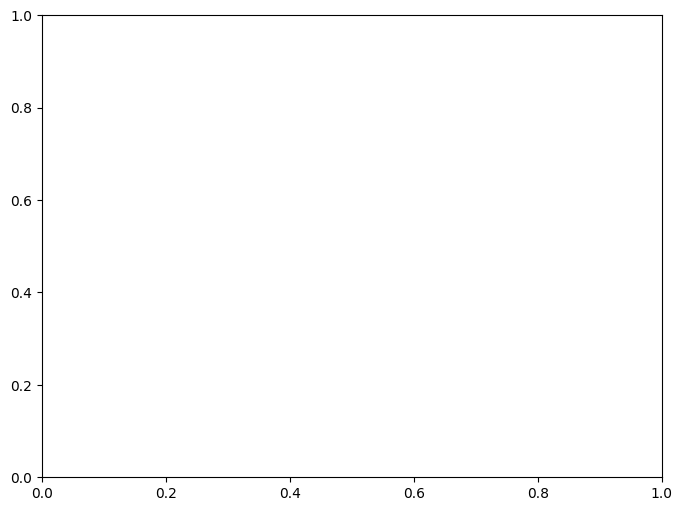

In [172]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the complex vectors
leadlag_pcs = ll_adata.varm['leadlag_pcs'][:, 0]
sim_vector = ll_adata.var['sim_cos'] + 1j * ll_adata.var['sim_sin']

# Calculate the phases (angles) of the complex vectors
leadlag_phases = np.angle(leadlag_pcs)
sim_phases = np.angle(sim_vector)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(sim_phases, phase_pyro.phis, alpha=0.6)

# Add labels and title
plt.xlabel('Simulated Phases (Sim Cos + i Sim Sin)')
plt.ylabel('Leadlag Phases (Leadlag PCs)')
plt.title('Phase Comparison: Simulated vs. Leadlag')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Display the plot
plt.tight_layout()
plt.show()
